In [2]:
import os
current_path = os.getcwd()
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import numpy as np
np.seterr(all='raise')
import matplotlib.pyplot as plt
from tqdm import tqdm
import myInput
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
sys.path.append(current_path+'/../calculate_tangent/')

# 3D Polycrystal Initial Condition Generator

This notebook creates a 3D polycrystalline microstructure with domain size 200×200×200 containing three grains with periodic boundary conditions:

- **Grain 0**: A cylinder from the center of one grain boundary with radius of 50 voxels and height of 50, with a half-sphere on one side
- **Grain 1**: A cylinder along grain 0 until the other grain boundary
- **Grain 2**: Occupies the remaining space in the domain

In [15]:

def generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height, GB_radius):
    """
    Generate a microstructure with two grains:
    - Grain 0: Cylinder with half-sphere at the top
    - Grain 1: Extending cylinder from the top of grain 0 to the end of the domain
    - Grain 2: Remaining space
    """
    # Parameters for grain 0 (cylinder with half-sphere)
    start_z = (nz - cylinder_radius) // 2  # Starting z position (1/4 of domain)
    # Define center of the domain
    center_x, center_y = nx // 2, ny // 2

    # Create a mask for checking points inside cylinder and half-sphere
    def is_in_cylinder_with_halfsphere(x, y, z, center_x, center_y, start_z, radius, height, GB_radius):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)

        # Check for cylinder part
        if dist_xy <= radius and start_z <= z < start_z + height:
            return True

        # Check for half-sphere part (top of cylinder)
        if z >= start_z + height:
            dist_center = np.sqrt(dist_xy**2 + (z - (start_z + height - np.sqrt(GB_radius**2 - radius**2)))**2)
            if dist_xy <= radius and dist_center <= GB_radius:
                return True

        # Check for half-sphere part (bottom of cylinder)
        if z <= start_z:
            dist_center = np.sqrt(dist_xy**2 + (z - (start_z + np.sqrt(GB_radius**2 - radius**2)))**2)
            if dist_xy <= radius and dist_center <= GB_radius:
                return True

        return False

    # Create a mask for checking points inside extending cylinder
    def is_in_extending_cylinder_plus(x, y, z, center_x, center_y, start_z, radius, height, grain_base):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)

        # The extending cylinder goes from half-sphere end to the end of domain
        if dist_xy <= radius and z >= start_z + height and not grain_base[x,y,z]:
            return True

        return False

    # Create a mask for checking points inside extending cylinder
    def is_in_extending_cylinder_mines(x, y, z, center_x, center_y, start_z, radius, grain_base):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)

        # The extending cylinder goes from half-sphere end to the end of domain
        if dist_xy <= radius and z <= start_z and not grain_base[x,y,z]:
            return True

        return False

    # Generate the microstructure
    # Fill in grain 0,1,2 (cylinder with half-sphere)
    grain0 = np.zeros((nx, ny, nz), dtype=bool)
    grain1 = np.zeros((nx, ny, nz), dtype=bool)
    grain2 = np.zeros((nx, ny, nz), dtype=bool)
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if is_in_cylinder_with_halfsphere(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height, GB_radius):
                    grain0[i, j, k] = True
                if is_in_extending_cylinder_plus(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height, grain0):
                    grain1[i, j, k] = True
                if is_in_extending_cylinder_mines(i, j, k, center_x, center_y, start_z, cylinder_radius, grain0):
                    grain2[i, j, k] = True


    # Fill in grain 2 (remaining space)
    grain3 = ~(grain0 | grain1 | grain2)

    # Convert to single array format
    P0 = grain0 * 1 + grain1 * 2 + grain2 * 3 + grain3 * 4

    return P0



In [ ]:

# Define cylinder domain dimensions in step 0
nx, ny, nz = 200, 200, 200
cylinder_radius = 50
cylinder_height_step0 = 50
GB_radius = 200
start_z_step0 = (nz - cylinder_height_step0) // 2

P0_step0 = generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height_step0, GB_radius)

# Define cylinder domain dimensions in step 1
cylinder_height_step1 = 70
start_z_step1 = (nz - cylinder_height_step0) // 2

P0_step1 = generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height_step1, GB_radius)


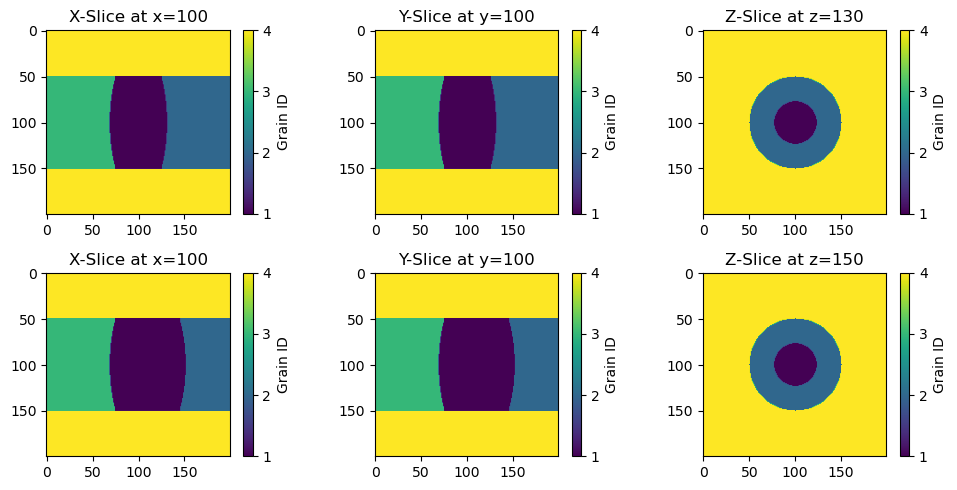

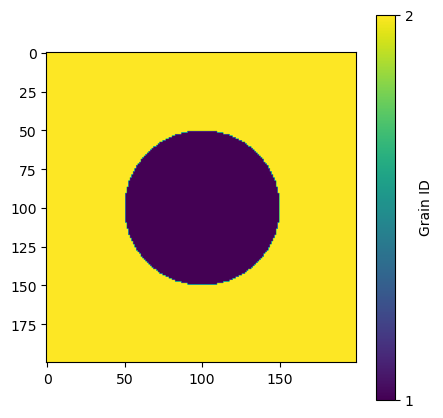

In [ ]:
# Visualize mid-slices
plt.figure(figsize=(10, 5))

# X-slice
plt.subplot(231)
plt.imshow(P0_step0[nx//2, :, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Y-slice
plt.subplot(232)
plt.imshow(P0_step0[:, ny//2, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(233)
plt.imshow(P0_step0[:, :, start_z_step0 + cylinder_height_step0 + 5], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Z-Slice at z={start_z_step0 + cylinder_height_step0 + 5}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# X-slice
plt.subplot(234)
plt.imshow(P0_step1[nx//2, :, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Y-slice
plt.subplot(235)
plt.imshow(P0_step1[:, ny//2, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(236)
plt.imshow(P0_step1[:, :, start_z_step1 + cylinder_height_step1 + 5], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Z-Slice at z={start_z_step1 + cylinder_height_step1 + 5}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

plt.tight_layout()
plt.show()


## Get curvature result from IO_curvature

In [129]:
import importlib
importlib.reload(post_processing)

# Calculate the curvature dictionary
curvature_dict_IO_step0 = post_processing.IO_curvature(P0_step0)
curvature_dict_IO_step1 = post_processing.IO_curvature(P0_step1)


In [130]:
print("Curvature matrix shape:", len(curvature_dict_IO_step0))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in curvature_dict_IO_step0.items():
    if key == 2:
        print(f"GB id in step 0: {key}, Value: {value}")
for key, value in curvature_dict_IO_step1.items():
    if key == 2:
        print(f"GB id in step 1: {key}, Value: {value}")
# analytical value
analytical_curvature = 1 / GB_radius
print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(curvature_dict_IO_step0[2][3],5)} error: {abs(analytical_curvature - curvature_dict_IO_step0[2][3])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 6
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [1.96800000e+03 1.94400000e+03 9.07700000e+03 2.07662839e-03]
GB id in step 1: 2, Value: [1.96800000e+03 1.94400000e+03 9.07700000e+03 2.07662839e-03]
Analytical curvature: 0.005, calculated curvature: 0.00208 error: 58.47%


## Get velocity from IO

In [ ]:

def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
    growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
    growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
    return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)

def compute_necessary_info_split(key,time_interval,
                            GB_infomation_dict_list_one_step_one_key,
                            npy_file_aniso_current,
                            npy_file_aniso_next):


    # Calculate dV and velocity
    dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
    velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
    # keep curvature
    current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]

    result = {
        "key": key,
        "velocity": velocity,
        "dV_direction1": dV_direction1,
        "dV_direction2": dV_direction2,
        "current_curvature_value": current_curvature_value,
        "is_anti_curvature": current_curvature_value * velocity < -1e-4 # not large difference, no GB in [-1e-4,0]
    }

    return result

time_interval = 1
# tmp_GB_infot_key2 = np.array([curvature_dict_IO_step0[2][2],0,0,0,curvature_dict_IO_step0[2][3],curvature_dict_IO_step0[2][2],1,2])
tmp_GB_infot_key2 = np.array([1.51300000e+04,0,0,0,curvature_dict_IO_step0[2][3],1.51300000e+04,1,2])
result = compute_necessary_info_split(key,time_interval,tmp_GB_infot_key2,P0_step0,P0_step1)

print("Velocity:", result["velocity"])
print("dV_direction1:", result["dV_direction1"])
print("dV_direction2:", result["dV_direction2"])
print("Current curvature value:", result["current_curvature_value"])
print("Is anti-curvature:", result["is_anti_curvature"])


Velocity: -31.110376734963648
dV_direction1: 0
dV_direction2: 235350
Current curvature value: -0.0020257448599181847
Is anti-curvature: False


## Get curvature from VECTOR

In [ ]:
from collections import defaultdict
from scipy.spatial import cKDTree

cores = 4
size_x,size_y,size_z = P0_step0.shape
grain_nums = 3
R = np.zeros((size_x,size_y,size_z,4))
R[:,:,:,3] = np.ones((size_x,size_y,size_z)) * (1 / GB_radius)

max_iteration = 20
filename_save = f"./BL3D_Cylinder_R{GB_radius}_Iteration_1_{max_iteration}"
BL_errors =np.zeros(max_iteration)
BL_runningTime = np.zeros(max_iteration)
for loop_times in tqdm(range(1,max_iteration)):
    smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step0,R,'p',verification_system = True,curvature_sign = True)
    smoothing_class.linear3d_main("curvature")
    C_ln = smoothing_class.get_C()
    curvature_matrix_step0 = C_ln[1,:]

    TJ_distance_max = loop_times

    # Create shifted arrays for all 6 directions at once
    neighbors = np.stack([
        np.roll(P0_step0, -1, axis=0),
        np.roll(P0_step0, 1, axis=0),
        np.roll(P0_step0, -1, axis=1),
        np.roll(P0_step0, 1, axis=1),
        np.roll(P0_step0, -1, axis=2),
        np.roll(P0_step0, 1, axis=2)
    ])

    # Find boundary voxels efficiently
    boundary_mask = (neighbors != P0_step0[None,...]).any(axis=0)
    boundary_coords = np.argwhere(boundary_mask)

    # First pass: Build TJ_information_dict and organize TJ points by pair_id
    TJ_infomation_dict = defaultdict(list)
    TJ_trees = {}  # KD-trees for each pair_id's TJ points
    neighbor_array = neighbors.reshape(6, -1).T

    # Process boundary points for triple junctions
    for idx, (i, j, k) in enumerate(boundary_coords):
        central_site = P0_step0[i,j,k]
        flat_idx = i * size_y * size_z + j * size_z + k
        neighbor_vals = neighbor_array[flat_idx]
        unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

        if len(unique_neighbors) > 1:  # Triple junction point
            for neighbor in unique_neighbors:
                pair_id = post_processing.get_line(central_site, neighbor)
                TJ_infomation_dict[pair_id].append([i,j,k])
    print("Finish TJ information collection")
    # Create KD-trees for each pair_id's TJ points
    for pair_id, tj_points in TJ_infomation_dict.items():
        tj_points_array = np.array(tj_points)
        TJ_trees[pair_id] = cKDTree(tj_points_array)

    # Second pass: Build GB_information_dict
    GB_infomation_dict = {}

    # Process boundary points for grain boundaries
    # Group boundary points by pair_id for batch processing
    gb_points_by_pair = defaultdict(list)
    gb_central_sites = defaultdict(list)
    gb_indices = defaultdict(list)

    for idx, (i, j, k) in enumerate(boundary_coords):
        central_site = P0_step0[i,j,k]
        flat_idx = i * size_y * size_z + j * size_z + k
        neighbor_vals = neighbor_array[flat_idx]
        unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

        if len(unique_neighbors) == 1:  # Single boundary point
            neighbor = unique_neighbors[0]
            pair_id = post_processing.get_line(central_site, neighbor)
            pair_id_pair = sorted([central_site, neighbor])

            # First update or create GB area count
            if pair_id in GB_infomation_dict:
                GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
            else:
                GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
                GB_infomation_dict[pair_id] = GB_infomation

            # Collect points for batch processing
            gb_points_by_pair[pair_id].append([i,j,k])
            gb_central_sites[pair_id].append(central_site)
            gb_indices[pair_id].append([i,j,k])
    print("Finish GB information collection")

    # Process each pair_id's points in batch
    for pair_id, points in gb_points_by_pair.items():
        points_array = np.array(points)
        central_sites = np.array(gb_central_sites[pair_id])
        indices = np.array(gb_indices[pair_id])

        # If there are TJ points for this pair_id, check distances
        if pair_id in TJ_trees:
            # Find distances to nearest TJ points for all GB points at once
            distances, _ = TJ_trees[pair_id].query(points_array)
            # Create mask for points far enough from TJ
            far_from_tj_mask = distances >= TJ_distance_max

            # Process only points far from TJ
            valid_points = points_array[far_from_tj_mask]
            valid_central_sites = central_sites[far_from_tj_mask]
            valid_indices = indices[far_from_tj_mask]

            # Update GB information for valid points
            n_valid = len(valid_points)
            if n_valid == 0: continue
            GB_infomation_dict[pair_id][0] += n_valid

            # Calculate curvature signs based on central_site matching pair_id_pair[0]
            curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)

            # Update position and curvature information
            pos_ave = np.sum(valid_indices, axis=0) / n_valid
            curv_ave = np.sum(curvature_signs * curvature_matrix_step0[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
            GB_infomation_dict[pair_id][1:4] += pos_ave
            GB_infomation_dict[pair_id][4] += curv_ave
    print("Finsh GB information dictionary")

    # Post-process GB information
    GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

    print(f"Current GBs len: {len(GB_infomation_dict)}")

    GB_infomation_dict_step0 = GB_infomation_dict.copy()

    # analytical value
    print('loop_times = ' + str(loop_times))
    analytical_curvature = 1 / GB_radius
    print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(GB_infomation_dict[2][4],5)} error: {abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature * 100:.2f}%")
    print('running_time = %.2f' % smoothing_class.running_time)
    print('running_core time = %.2f' % smoothing_class.running_coreTime)
    print()
    BL_errors[loop_times-1] = abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature
    BL_runningTime[loop_times-1] = smoothing_class.running_coreTime

np.savez(filename_save, BL_errors=BL_errors, BL_runningTime=BL_runningTime)

  # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step1,R,'p',verification_system = True,curvature_sign = True)
  # smoothing_class.linear3d_main("curvature")
  # C_ln = smoothing_class.get_C()
  # curvature_matrix_step1 = C_ln[1,:]

  0%|          | 0/19 [00:00<?, ?it/s]


my core time is 182.849441
my core time is 181.011821
my core time is 174.356307
my core time is 177.805744
my core time is 170.52209
my core time is 169.427568
my core time is 174.217884
res_back start...
my res time is 0.131976
res_back start...
my res time is 0.119097
res_back start...
my res time is 0.101431
res_back start...
my res time is 0.082064
my core time is 5.718361
res_back start...
my res time is 0.210586
my core time is 5.894487
res_back start...
my res time is 0.078166
res_back start...
my res time is 0.078913
res_back start...
my res time is 0.129486
res_back start...
my res time is 0.103532
my core time is 6.731116
res_back start...
my res time is 0.175772
my core time is 6.721934
res_back start...
my res time is 0.143564
core done!
Finish TJ information collection
Finish GB information collection


  5%|▌         | 1/19 [01:17<23:12, 77.35s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 1
Analytical curvature: 0.005, calculated curvature: 0.00015 error: 96.99%
running_time = 31.05
running_core time = 6.73


my core time is 65.477167
res_back start...
my res time is 0.105634
my core time is 65.715499
res_back start...
my res time is 0.088344
my core time is 65.987327
my core time is 64.472339
res_back start...
my res time is 0.06639
res_back start...
my res time is 0.080095
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6
loop_times = 2
Analytical curvature: 0.005, calculated curvature: 0.00228 error: 54.45%
running_time = 84.33
running_core time = 65.99



 11%|█         | 2/19 [03:28<30:57, 109.26s/it]


my core time is 104.423754
res_back start...
my res time is 0.124213
my core time is 122.94475
res_back start...
my res time is 0.088788
my core time is 132.862336
res_back start...
my res time is 0.133434
my core time is 131.955239
res_back start...
my res time is 0.082404
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6
loop_times = 3
Analytical curvature: 0.005, calculated curvature: 0.00573 error: 14.54%
running_time = 148.06
running_core time = 132.86



 16%|█▌        | 3/19 [06:47<39:58, 149.93s/it]


my core time is 136.723961
res_back start...
my res time is 0.096386
my core time is 138.822102
res_back start...
my res time is 0.091997
my core time is 138.42652
my core time is 137.367264
res_back start...
my res time is 0.115063
res_back start...
my res time is 0.135117
core done!
Finish TJ information collection
Finish GB information collection


 21%|██        | 4/19 [10:15<43:17, 173.13s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 4
Analytical curvature: 0.005, calculated curvature: 0.00583 error: 16.62%
running_time = 160.91
running_core time = 138.82


my core time is 158.901798
res_back start...
my res time is 0.104374
my core time is 159.34945
res_back start...
my res time is 0.079579
my core time is 160.582948
my core time is 159.488314
res_back start...
my res time is 0.108443
res_back start...
my res time is 0.097587
core done!
Finish TJ information collection
Finish GB information collection


 26%|██▋       | 5/19 [14:02<44:52, 192.31s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 5
Analytical curvature: 0.005, calculated curvature: 0.00518 error: 3.64%
running_time = 177.68
running_core time = 160.58


my core time is 198.822893
res_back start...
my res time is 0.195818
my core time is 202.577284
res_back start...
my res time is 0.131732
my core time is 206.227054
res_back start...
my res time is 0.135791
my core time is 205.467989
res_back start...
my res time is 0.106839
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary

 32%|███▏      | 6/19 [18:31<47:20, 218.49s/it]


Current GBs len: 6
loop_times = 6
Analytical curvature: 0.005, calculated curvature: 0.0051 error: 1.99%
running_time = 222.40
running_core time = 206.23


my core time is 229.956171
res_back start...
my res time is 0.134201
my core time is 240.20158
res_back start...
my res time is 0.106026
my core time is 248.46291
res_back start...
my res time is 0.14253
my core time is 247.291006
res_back start...
my res time is 0.111301
core done!
Finish TJ information collection
Finish GB information collection


 37%|███▋      | 7/19 [23:43<49:48, 249.01s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 7
Analytical curvature: 0.005, calculated curvature: 0.00541 error: 8.13%
running_time = 265.12
running_core time = 248.46


my core time is 279.553758
res_back start...
my res time is 0.123492
my core time is 290.767734
res_back start...
my res time is 0.133888
my core time is 300.503271
res_back start...
my res time is 0.113861
my core time is 300.140745
res_back start...
my res time is 0.077748
core done!
Finish TJ information collection
Finish GB information collection


 42%|████▏     | 8/19 [29:48<52:24, 285.88s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 8
Analytical curvature: 0.005, calculated curvature: 0.00546 error: 9.29%
running_time = 320.08
running_core time = 300.50


my core time is 335.389438
res_back start...
my res time is 0.094188
my core time is 337.974286
res_back start...
my res time is 0.149197
my core time is 347.519619
res_back start...
my res time is 0.109328
my core time is 346.364457
res_back start...
my res time is 0.108713
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6
loop_times = 9
Analytical curvature: 0.005, calculated curvature: 0.00521 error: 4.16%
running_time = 367.77
running_core time = 347.52



 47%|████▋     | 9/19 [36:40<54:13, 325.38s/it]


my core time is 382.343759
res_back start...
my res time is 0.120478
my core time is 384.404908
res_back start...
my res time is 0.115541
my core time is 389.235899
res_back start...
my res time is 0.095725
my core time is 389.337143
res_back start...
my res time is 0.119429
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6
loop_times = 10
Analytical curvature: 0.005, calculated curvature: 0.00504 error: 0.89%
running_time = 410.81
running_core time = 389.34



 53%|█████▎    | 10/19 [44:24<55:12, 368.09s/it]


my core time is 452.679845
res_back start...
my res time is 0.092409
my core time is 453.767673
res_back start...
my res time is 0.098829
my core time is 457.690747
res_back start...
my res time is 0.107159
my core time is 458.157464
res_back start...
my res time is 0.10345
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary

 58%|█████▊    | 11/19 [53:14<55:42, 417.80s/it]


Current GBs len: 6
loop_times = 11
Analytical curvature: 0.005, calculated curvature: 0.00512 error: 2.47%
running_time = 481.14
running_core time = 458.16


my core time is 479.816746
res_back start...
my res time is 0.120632
my core time is 479.950159
res_back start...
my res time is 0.083558
my core time is 489.451447
my core time is 487.387667
res_back start...
my res time is 0.088012
res_back start...
my res time is 0.098288
core done!
Finish TJ information collection
Finish GB information collection


 63%|██████▎   | 12/19 [1:02:37<53:52, 461.79s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 12
Analytical curvature: 0.005, calculated curvature: 0.00522 error: 4.45%
running_time = 510.17
running_core time = 489.45


my core time is 521.288925
res_back start...
my res time is 0.201844
my core time is 523.168585
res_back start...
my res time is 0.085495
my core time is 528.973648
res_back start...
my res time is 0.087066
my core time is 529.125354
res_back start...
my res time is 0.228957
core done!
Finish TJ information collection
Finish GB information collection


 68%|██████▊   | 13/19 [1:12:40<50:27, 504.59s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 13
Analytical curvature: 0.005, calculated curvature: 0.00521 error: 4.21%
running_time = 548.59
running_core time = 529.13


my core time is 582.10109
res_back start...
my res time is 0.174132
my core time is 584.850699
res_back start...
my res time is 0.11381
my core time is 593.688851
res_back start...
my res time is 0.162103
my core time is 593.923502
res_back start...
my res time is 0.117016
core done!
Finish TJ information collection
Finish GB information collection


 74%|███████▎  | 14/19 [1:23:51<46:14, 554.87s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 14
Analytical curvature: 0.005, calculated curvature: 0.00508 error: 1.60%
running_time = 614.34
running_core time = 593.92


my core time is 648.085714
res_back start...
my res time is 0.183851
my core time is 658.922779
res_back start...
my res time is 0.088085
my core time is 672.526562
res_back start...
my res time is 0.065609
my core time is 676.062104
res_back start...
my res time is 0.10582
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary

 79%|███████▉  | 15/19 [1:36:21<40:55, 613.78s/it]


Current GBs len: 6
loop_times = 15
Analytical curvature: 0.005, calculated curvature: 0.00498 error: 0.48%
running_time = 692.04
running_core time = 676.06


my core time is 758.905277
res_back start...
my res time is 0.169543
my core time is 781.917925
res_back start...
my res time is 0.156177
my core time is 785.716508
res_back start...
my res time is 0.075563
my core time is 801.558858
res_back start...
my res time is 0.140704
core done!
Finish TJ information collection
Finish GB information collection


 84%|████████▍ | 16/19 [1:51:05<34:45, 695.04s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 16
Analytical curvature: 0.005, calculated curvature: 0.005 error: 0.10%
running_time = 822.86
running_core time = 801.56


my core time is 874.090296
res_back start...
my res time is 0.056866
my core time is 876.581031
res_back start...
my res time is 0.144268
my core time is 895.792381
res_back start...
my res time is 0.057948
my core time is 905.985215
res_back start...
my res time is 0.122059
core done!
Finish TJ information collection
Finish GB information collection


 89%|████████▉ | 17/19 [2:07:34<26:07, 783.51s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 17
Analytical curvature: 0.005, calculated curvature: 0.00509 error: 1.90%
running_time = 926.63
running_core time = 905.99


my core time is 920.997107
res_back start...
my res time is 0.099377
my core time is 922.016928
res_back start...
my res time is 0.078285
my core time is 920.532547
res_back start...
my res time is 0.140506
my core time is 924.269531
res_back start...
my res time is 0.076855
core done!
Finish TJ information collection
Finish GB information collection


 95%|█████████▍| 18/19 [2:24:01<14:04, 844.57s/it]

Finsh GB information dictionary
Current GBs len: 6
loop_times = 18
Analytical curvature: 0.005, calculated curvature: 0.00518 error: 3.60%
running_time = 945.27
running_core time = 924.27


my core time is 581.342901
my core time is 580.848523
res_back start...
my res time is 0.148783
res_back start...
my res time is 0.083893
my core time is 586.339669
res_back start...
my res time is 0.1005
my core time is 593.755527
res_back start...
my res time is 0.11629
core done!
Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary

100%|██████████| 19/19 [2:34:51<00:00, 489.05s/it]


Current GBs len: 6
loop_times = 19
Analytical curvature: 0.005, calculated curvature: 0.00516 error: 3.25%
running_time = 609.94
running_core time = 593.76



Process SpawnPoolWorker-8999411:
Traceback (most recent call last):
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, '\x27'.
Process SpawnPoolWorker-8999413:
Traceback (most recent call last):
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/lin/mambaforge3/envs/moose/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Us

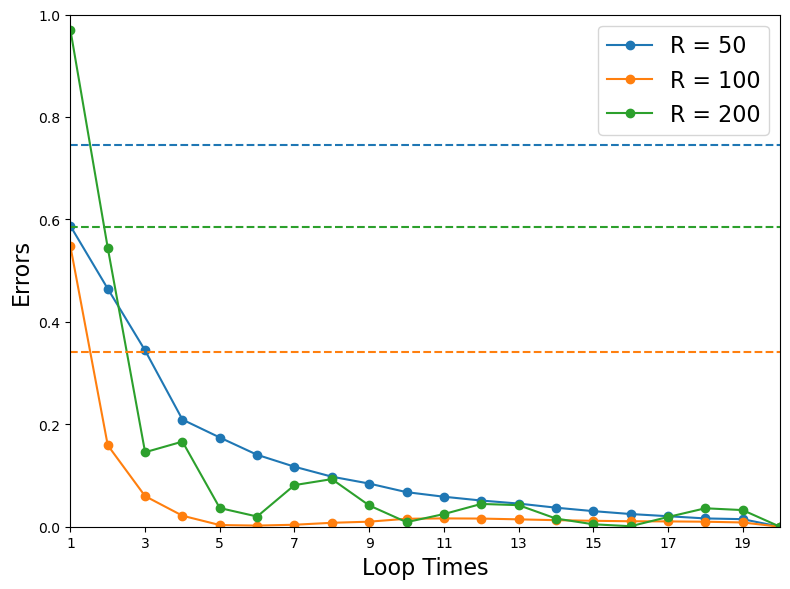

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for the three cases
case_files = [
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Cylinder_R50_Iteration_1_20.npz",
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Cylinder_R100_Iteration_1_20.npz",
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Cylinder_R200_Iteration_1_20.npz"
]

# Load data for each case
BL_errors_cases = []
for file in case_files:
    data = np.load(file)
    BL_errors_cases.append(data['BL_errors'])

loop_times = np.arange(1, len(BL_errors_cases[0]) + 1)

# Plot BL_errors for the three cases
plt.figure(figsize=(5,4))
labels = ["R = 50", "R = 100", "R = 200"]
for i, BL_errors in enumerate(BL_errors_cases):
    plt.plot(loop_times, BL_errors, label=f"{labels[i]}", c=f"C{i}", marker='o')

# plot results from I-O method
I_O_method_results = [0.7445, 0.3420, 0.5847]

for i, I_O_method_result in enumerate(I_O_method_results):
    plt.plot(loop_times, [I_O_method_result] * len(loop_times), c=f"C{i}", linestyle='--')

plt.xlabel("Iterations",fontsize=16)
plt.ylabel("Errors",fontsize=16)
plt.xlim(1, 20)
plt.xticks(np.arange(1, 21, 2))
plt.ylim(0, 1)
plt.legend(fontsize=16)
# plt.grid(True)
plt.tight_layout()
plt.savefig("BL3D_Cylinder_3Radius.png", dpi=300)

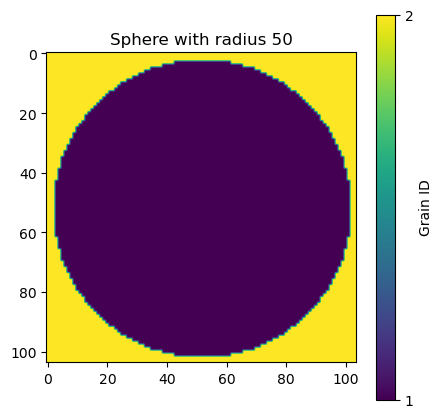

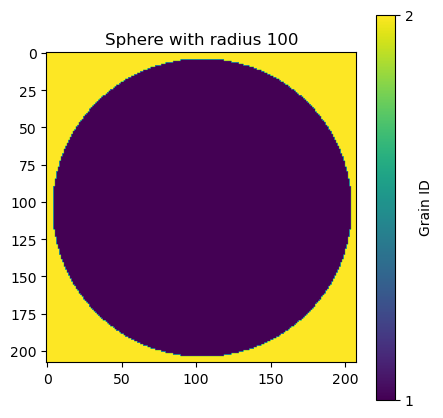

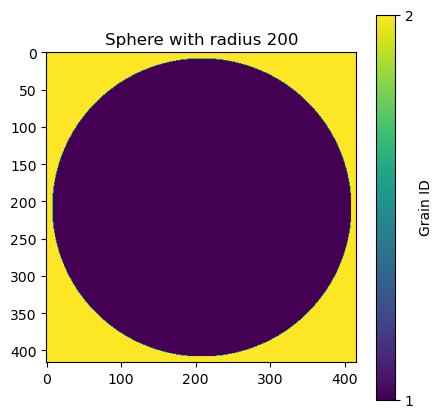

In [14]:
# Create a mask for the sphere grains
P0_sphere_list = []
for sphere_radius in [50, 100, 200]:
    # Create a sphere with the specified radius
    nx, ny, nz = int(sphere_radius*2.08), int(sphere_radius*2.08), int(sphere_radius*2.08)
    microstructure, _ = myInput.Circle_IC3d(nx, ny, nz, sphere_radius)
    P0_sphere_step0 = microstructure[:,:,:,0]*1 + microstructure[:,:,:,1]*2
    P0_sphere_list.append(P0_sphere_step0) 
    # Visualize the sphere
    plt.figure(figsize=(5, 5))
    plt.imshow(P0_sphere_step0[nx//2, :, :], cmap='viridis', vmin=1, vmax=2)
    plt.colorbar(ticks=[1, 2], label='Grain ID')
    plt.title(f"Sphere with radius {sphere_radius}")


In [24]:
from collections import defaultdict
from scipy.spatial import cKDTree


GB_radius_list = [50, 100, 200]
for i in range(len(P0_sphere_list)):
    P0_step0 = P0_sphere_list[i]
    GB_radius = GB_radius_list[i]

    cores = 8
    size_x,size_y,size_z = P0_step0.shape
    grain_nums = 2
    R = np.zeros((size_x,size_y,size_z,4))

    max_iteration = 20
    filename_save = f"./BL3D_Curvature_R{GB_radius}_Iteration_1_{max_iteration}_new"
    BL_errors =np.zeros(max_iteration)
    BL_runningTime = np.zeros(max_iteration)
    for loop_times in tqdm(range(1,max_iteration)):
        smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step0,R,'p',verification_system = True,curvature_sign = True)
        smoothing_class.linear3d_main("curvature")
        C_ln = smoothing_class.get_C()
        curvature_matrix_step0 = C_ln[1,:]

        TJ_distance_max = loop_times

        # Create shifted arrays for all 6 directions at once
        neighbors = np.stack([
            np.roll(P0_step0, -1, axis=0),
            np.roll(P0_step0, 1, axis=0),
            np.roll(P0_step0, -1, axis=1),
            np.roll(P0_step0, 1, axis=1),
            np.roll(P0_step0, -1, axis=2),
            np.roll(P0_step0, 1, axis=2)
        ])

        # Find boundary voxels efficiently
        boundary_mask = (neighbors != P0_step0[None,...]).any(axis=0)
        boundary_coords = np.argwhere(boundary_mask)

        # First pass: Build TJ_information_dict and organize TJ points by pair_id
        TJ_infomation_dict = defaultdict(list)
        TJ_trees = {}  # KD-trees for each pair_id's TJ points
        neighbor_array = neighbors.reshape(6, -1).T

        # Process boundary points for triple junctions
        for idx, (i, j, k) in enumerate(boundary_coords):
            central_site = P0_step0[i,j,k]
            flat_idx = i * size_y * size_z + j * size_z + k
            neighbor_vals = neighbor_array[flat_idx]
            unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

            if len(unique_neighbors) > 1:  # Triple junction point
                for neighbor in unique_neighbors:
                    pair_id = post_processing.get_line(central_site, neighbor)
                    TJ_infomation_dict[pair_id].append([i,j,k])
        print("Finish TJ information collection")
        # Create KD-trees for each pair_id's TJ points
        for pair_id, tj_points in TJ_infomation_dict.items():
            tj_points_array = np.array(tj_points)
            TJ_trees[pair_id] = cKDTree(tj_points_array)

        # Second pass: Build GB_information_dict
        GB_infomation_dict = {}

        # Process boundary points for grain boundaries
        # Group boundary points by pair_id for batch processing
        gb_points_by_pair = defaultdict(list)
        gb_central_sites = defaultdict(list)
        gb_indices = defaultdict(list)

        for idx, (i, j, k) in enumerate(boundary_coords):
            central_site = P0_step0[i,j,k]
            flat_idx = i * size_y * size_z + j * size_z + k
            neighbor_vals = neighbor_array[flat_idx]
            unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

            if len(unique_neighbors) == 1:  # Single boundary point
                neighbor = unique_neighbors[0]
                pair_id = post_processing.get_line(central_site, neighbor)
                pair_id_pair = sorted([central_site, neighbor])

                # First update or create GB area count
                if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
                else:
                    GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
                    GB_infomation_dict[pair_id] = GB_infomation

                # Collect points for batch processing
                gb_points_by_pair[pair_id].append([i,j,k])
                gb_central_sites[pair_id].append(central_site)
                gb_indices[pair_id].append([i,j,k])
        print("Finish GB information collection")

        # Process each pair_id's points in batch
        for pair_id, points in gb_points_by_pair.items():
            points_array = np.array(points)
            central_sites = np.array(gb_central_sites[pair_id])
            indices = np.array(gb_indices[pair_id])

            # If there are TJ points for this pair_id, check distances
            if pair_id in TJ_trees:
                # Find distances to nearest TJ points for all GB points at once
                distances, _ = TJ_trees[pair_id].query(points_array)
                # Create mask for points far enough from TJ
                far_from_tj_mask = distances >= TJ_distance_max

                # Process only points far from TJ
                valid_points = points_array[far_from_tj_mask]
                valid_central_sites = central_sites[far_from_tj_mask]
                valid_indices = indices[far_from_tj_mask]
            else:
                # If no TJ points, consider all points as valid
                valid_points = points_array
                valid_central_sites = central_sites
                valid_indices = indices

            # Update GB information for valid points
            n_valid = len(valid_points)
            if n_valid == 0: continue
            GB_infomation_dict[pair_id][0] += n_valid

            # Calculate curvature signs based on central_site matching pair_id_pair[0]
            curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)

            # Update position and curvature information
            pos_ave = np.sum(valid_indices, axis=0) / n_valid
            curv_ave = np.sum(curvature_signs * curvature_matrix_step0[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
            GB_infomation_dict[pair_id][1:4] += pos_ave
            GB_infomation_dict[pair_id][4] += curv_ave
        print("Finsh GB information dictionary")

        # Post-process GB information
        GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

        print(f"Current GBs len: {len(GB_infomation_dict)}")

        GB_infomation_dict_step0 = GB_infomation_dict.copy()

        # analytical value
        print('loop_times = ' + str(loop_times))
        analytical_curvature = 1 / GB_radius
        print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(GB_infomation_dict[2][4],5)} error: {abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature * 100:.2f}%")
        print('running_time = %.2f' % smoothing_class.running_time)
        print('running_core time = %.2f' % smoothing_class.running_coreTime)
        print()
        BL_errors[loop_times-1] = abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature
        BL_runningTime[loop_times-1] = smoothing_class.running_coreTime

    np.savez(filename_save, BL_errors=BL_errors, BL_runningTime=BL_runningTime)

  # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step1,R,'p',verification_system = True,curvature_sign = True)
  # smoothing_class.linear3d_main("curvature")
  # C_ln = smoothing_class.get_C()
  # curvature_matrix_step1 = C_ln[1,:]

  0%|          | 0/19 [00:00<?, ?it/s]


my core time is 0.601355
res_back start...
my res time is 0.003577
my core time is 0.616787
res_back start...
my res time is 0.001068
my core time is 0.61109
my core time is 0.601355
res_back start...
my res time is 0.003577
my core time is 0.616787
res_back start...
my res time is 0.001068
my core time is 0.61109
res_back start...
my res time is 0.001325
my core time is 0.565976
res_back start...
my res time is 0.000289
my core time is 0.559917
res_back start...
res_back start...
my res time is 0.001325
my core time is 0.565976
res_back start...
my res time is 0.000289
my core time is 0.559917
res_back start...
my res time is 0.000313
my core time is 0.529254
res_back start...
my res time is 0.000403
my core time is 0.486412
res_back start...
my res time is 0.000348
my res time is 0.000313
my core time is 0.529254
res_back start...
my res time is 0.000403
my core time is 0.486412
res_back start...
my res time is 0.000348
my core time is 0.41026
res_back start...
my res time is 0.0002

  5%|▌         | 1/19 [00:07<02:20,  7.80s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 1
Analytical curvature: 0.02, calculated curvature: 0.01834 error: 8.31%
running_time = 3.39
running_core time = 0.62



my core time is 1.675293
res_back start...
my res time is 0.003074
my core time is 1.666237
res_back start...
my res time is 0.000904
my core time is 1.675293
res_back start...
my res time is 0.003074
my core time is 1.666237
res_back start...
my res time is 0.000904
my core time is 1.594607
res_back start...
my res time is 0.000296
my core time is 1.766181
my core time is 1.909007
res_back start...
my res time is 0.000362
res_back start...
my res time is 0.000585
my core time is 1.594607
res_back start...
my res time is 0.000296
my core time is 1.766181
my core time is 1.909007
res_back start...
my res time is 0.000362
res_back start...
my res time is 0.000585
my core time is 1.836319
my core time is 1.739082
res_back start...
my res time is 0.000551
res_back start...
my

 11%|█         | 2/19 [00:16<02:20,  8.29s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 2
Analytical curvature: 0.02, calculated curvature: 0.01896 error: 5.22%
running_time = 4.38
running_core time = 1.91



my core time is 2.043069
res_back start...
my res time is 0.002434
my core time is 2.411829
res_back start...
my res time is 0.000945
my core time is 1.969739
my core time is 2.326989
my core time is 2.043069
res_back start...
my res time is 0.002434
my core time is 2.411829
res_back start...
my res time is 0.000945
my core time is 1.969739
my core time is 2.326989
res_back start...
my res time is 0.001
my core time is 2.460858
res_back start...
my res time is 0.000324
res_back start...
my core time is 1.970634
my res time is 0.000328
res_back start...
my res time is 0.000324
my core time is 2.222249
res_back start...
my res time is 0.000389
my core time is 1.99602
res_back start...
res_back start...
my res time is 0.001
my core time is 2.460858
res_back start...
my res t

 16%|█▌        | 3/19 [00:25<02:17,  8.58s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 3
Analytical curvature: 0.02, calculated curvature: 0.01921 error: 3.94%
running_time = 4.76
running_core time = 2.46



my core time is 2.813306
res_back start...
my res time is 0.002755
my core time is 2.746998
my core time is 2.813306
res_back start...
my res time is 0.002755
my core time is 2.746998
my core time is 2.896997
res_back start...
my res time is 0.001265
res_back start...
my res time is 0.000446
my core time is 2.696846
res_back start...
my res time is 0.00033
my core time is 2.896997
res_back start...
my res time is 0.001265
res_back start...
my res time is 0.000446
my core time is 2.696846
res_back start...
my res time is 0.00033
my core time is 2.995852
res_back start...
my res time is 0.000302
my core time is 2.665457
res_back start...
my res time is 0.000678
my core time is 2.636034
res_back start...
my res time is 0.00054
my core time is 2.995852
res_back start...
my re

 21%|██        | 4/19 [00:35<02:18,  9.24s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 4
Analytical curvature: 0.02, calculated curvature: 0.01936 error: 3.21%
running_time = 5.90
running_core time = 3.31



my core time is 3.696728
res_back start...
my res time is 0.002529
my core time is 3.7021
res_back start...
my res time is 0.001062
my core time is 3.63968
my core time is 3.696728
res_back start...
my res time is 0.002529
my core time is 3.7021
res_back start...
my res time is 0.001062
my core time is 3.63968
res_back start...
my res time is 0.001089
my core time is 3.745064
res_back start...
my res time is 0.000766
my core time is 3.655129
res_back start...
my res time is 0.000351
res_back start...
my res time is 0.001089
my core time is 3.745064
res_back start...
my res time is 0.000766
my core time is 3.655129
res_back start...
my res time is 0.000351
my core time is 3.598648
my core time is 3.717592
res_back start...
my res time is 0.000692
res_back start...
my res t

 26%|██▋       | 5/19 [00:46<02:15,  9.66s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 5
Analytical curvature: 0.02, calculated curvature: 0.01946 error: 2.72%
running_time = 6.20
running_core time = 3.75



my core time is 4.483997
res_back start...
my res time is 0.002657
my core time is 4.315438
res_back start...
my res time is 0.00114
my core time is 4.302976
res_back start...
my res time is 0.00041
my core time is 4.483997
res_back start...
my res time is 0.002657
my core time is 4.315438
res_back start...
my res time is 0.00114
my core time is 4.302976
res_back start...
my res time is 0.00041
my core time is 4.981887
res_back start...
my res time is 0.000349
my core time is 4.994137
my core time is 4.981887
res_back start...
my res time is 0.000349
my core time is 4.994137
res_back start...
my res time is 0.00086
res_back start...
my res time is 0.00086
my core time is 4.673341
res_back start...
my res time is 0.000291
my core time is 4.673341
res_back start...
my res t

 32%|███▏      | 6/19 [00:57<02:14, 10.37s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 6
Analytical curvature: 0.02, calculated curvature: 0.01953 error: 2.37%
running_time = 7.58
running_core time = 5.40



my core time is 8.036397
res_back start...
my res time is 0.003185
my core time is 8.036397
res_back start...
my res time is 0.003185
my core time is 8.598057
res_back start...
my res time is 0.002113
my core time is 8.598057
res_back start...
my res time is 0.002113
my core time is 8.883403
res_back start...
my res time is 0.001823
my core time is 8.648523
res_back start...
my res time is 0.000871
my core time is 8.883403
res_back start...
my res time is 0.001823
my core time is 8.648523
res_back start...
my res time is 0.000871
my core time is 9.157656
my core time is 8.75254
res_back start...
my res time is 0.000837
res_back start...
my res time is 0.000829
my core time is 8.939762
res_back start...
my res time is 0.000328
my core time is 9.157656
my core time is 8.752

 37%|███▋      | 7/19 [01:14<02:27, 12.31s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 7
Analytical curvature: 0.02, calculated curvature: 0.01958 error: 2.10%
running_time = 11.75
running_core time = 9.16



my core time is 8.924403
res_back start...
my res time is 0.003965
my core time is 8.924403
res_back start...
my res time is 0.003965
my core time is 8.986544
res_back start...
my res time is 0.002014
my core time is 8.986544
res_back start...
my res time is 0.002014
my core time is 8.993444
my core time is 9.143187
res_back start...
my res time is 0.000627
res_back start...
my res time is 0.000593
my core time is 8.944394
res_back start...
my res time is 0.0006
my core time is 8.993444
my core time is 9.143187
res_back start...
my res time is 0.000627
res_back start...
my res time is 0.000593
my core time is 8.944394
res_back start...
my res time is 0.0006
my core time is 8.956748
res_back start...
my res time is 0.000425
my core time is 8.956748
res_back start...
my re

 42%|████▏     | 8/19 [01:31<02:34, 14.04s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 8
Analytical curvature: 0.02, calculated curvature: 0.01962 error: 1.90%
running_time = 13.34
running_core time = 10.85



my core time is 9.583301
res_back start...
my res time is 0.003674
my core time is 9.583301
res_back start...
my res time is 0.003674
my core time is 12.852085
res_back start...
my res time is 0.001945
my core time is 12.689093
res_back start...
my res time is 0.000485
my core time is 12.852085
res_back start...
my res time is 0.001945
my core time is 12.689093
res_back start...
my res time is 0.000485
my core time is 12.499698
res_back start...
my res time is 0.000346
my core time is 13.042772
my core time is 12.499698
res_back start...
my res time is 0.000346
my core time is 13.042772
res_back start...
my res time is 0.001454
res_back start...
my res time is 0.001454
my core time is 13.681899
res_back start...
my res time is 0.000702
my core time is 13.299502
res_back

 47%|████▋     | 9/19 [01:52<02:40, 16.06s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 9
Analytical curvature: 0.02, calculated curvature: 0.01965 error: 1.76%
running_time = 16.19
running_core time = 13.68



my core time is 14.350518
res_back start...
my res time is 0.003347
my core time is 14.350518
res_back start...
my res time is 0.003347
my core time is 14.330305
res_back start...
my res time is 0.001451
my core time is 14.55394
res_back start...
my res time is 0.000785
my core time is 14.732419
my core time is 14.330305
res_back start...
my res time is 0.001451
my core time is 14.55394
res_back start...
my res time is 0.000785
my core time is 14.732419
res_back start...
my res time is 0.001056
my core time is 14.882921
res_back start...
my res time is 0.000969
my core time is 14.555138
res_back start...
my res time is 0.000398
res_back start...
my res time is 0.001056
my core time is 14.882921
res_back start...
my res time is 0.000969
my core time is 14.555138
res_back

 53%|█████▎    | 10/19 [02:15<02:45, 18.40s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 10
Analytical curvature: 0.02, calculated curvature: 0.01967 error: 1.66%
running_time = 19.34
running_core time = 16.78



my core time is 19.587067
res_back start...
my res time is 0.00272
my core time is 19.587067
res_back start...
my res time is 0.00272
my core time is 19.984683
res_back start...
my res time is 0.001366
my core time is 20.005045
res_back start...
my res time is 0.000817
my core time is 19.984683
res_back start...
my res time is 0.001366
my core time is 20.005045
res_back start...
my res time is 0.000817
my core time is 20.212636
res_back start...
my res time is 0.000625
my core time is 20.121573
res_back start...
my res time is 0.000448
my core time is 20.212636
res_back start...
my res time is 0.000625
my core time is 20.121573
res_back start...
my res time is 0.000448
my core time is 20.081439
res_back start...
my res time is 0.000891
my core time is 20.053149
res_bac

 58%|█████▊    | 11/19 [02:45<02:55, 21.96s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 11
Analytical curvature: 0.02, calculated curvature: 0.01968 error: 1.59%
running_time = 25.64
running_core time = 23.42



my core time is 27.056349
res_back start...
my res time is 0.003774
my core time is 27.056349
res_back start...
my res time is 0.003774
my core time is 27.503428
res_back start...
my res time is 0.001417
my core time is 27.452538
res_back start...
my res time is 0.000428
my core time is 27.374703
my core time is 27.503428
res_back start...
my res time is 0.001417
my core time is 27.452538
res_back start...
my res time is 0.000428
my core time is 27.374703
res_back start...
my res time is 0.001484
res_back start...
my res time is 0.001484
my core time is 27.512041
res_back start...
my res time is 0.000721
my core time is 27.773586
res_back start...
my res time is 0.000682
my core time is 27.589454
my core time is 27.512041
res_back start...
my res time is 0.000721
my co

 63%|██████▎   | 12/19 [03:20<03:01, 25.90s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 12
Analytical curvature: 0.02, calculated curvature: 0.01969 error: 1.56%
running_time = 30.41
running_core time = 27.77



my core time is 33.999924
res_back start...
my res time is 0.00345
my core time is 33.999924
res_back start...
my res time is 0.00345
my core time is 34.685961
res_back start...
my res time is 0.001356
my core time is 34.685961
res_back start...
my res time is 0.001356
my core time is 34.811428
res_back start...
my res time is 0.001432
my core time is 34.811428
res_back start...
my res time is 0.001432
my core time is 34.882854
res_back start...
my res time is 0.000942
my core time is 34.882854
res_back start...
my res time is 0.000942
my core time is 35.244306
res_back start...
my res time is 0.000546
my core time is 35.098154
res_back start...
my res time is 0.000311
my core time is 34.994972
res_back start...
my res time is 0.000715
my core time is 35.244306
res_bac

 68%|██████▊   | 13/19 [04:03<03:05, 30.89s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 13
Analytical curvature: 0.02, calculated curvature: 0.01969 error: 1.55%
running_time = 37.92
running_core time = 35.24



my core time is 41.03102
res_back start...
my res time is 0.003196
my core time is 41.03102
res_back start...
my res time is 0.003196
my core time is 41.962406
res_back start...
my res time is 0.001849
my core time is 42.267112
my core time is 41.962406
res_back start...
my res time is 0.001849
my core time is 42.267112
res_back start...
my res time is 0.004236
my core time is 41.99834
res_back start...
my res time is 0.000674
res_back start...
my res time is 0.004236
my core time is 41.99834
res_back start...
my res time is 0.000674
my core time is 42.519729
res_back start...
my res time is 0.001409
my core time is 42.392512
res_back start...
my res time is 0.000492
my core time is 42.324598
res_back start...
my res time is 0.001084
my core time is 42.519729
res_back 

 74%|███████▎  | 14/19 [04:53<03:03, 36.71s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 14
Analytical curvature: 0.02, calculated curvature: 0.01969 error: 1.57%
running_time = 45.56
running_core time = 42.55



my core time is 42.957091
res_back start...
my res time is 0.003154
my core time is 42.957091
res_back start...
my res time is 0.003154
my core time is 49.878222
res_back start...
my res time is 0.001097
my core time is 49.878222
res_back start...
my res time is 0.001097
my core time is 50.497808
res_back start...
my res time is 0.001356
my core time is 50.497808
res_back start...
my res time is 0.001356
my core time is 50.881542
res_back start...
my res time is 0.000861
my core time is 50.754949
res_back start...
my res time is 0.000617
my core time is 50.881542
res_back start...
my res time is 0.000861
my core time is 50.754949
res_back start...
my res time is 0.000617
my core time is 51.529357
res_back start...
my res time is 0.000344
my core time is 51.425961
res_b

 79%|███████▉  | 15/19 [05:52<02:53, 43.34s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 15
Analytical curvature: 0.02, calculated curvature: 0.01968 error: 1.62%
running_time = 54.06
running_core time = 51.53



my core time is 58.635284
res_back start...
my res time is 0.003588
my core time is 58.635284
res_back start...
my res time is 0.003588
my core time is 59.668485
res_back start...
my res time is 0.001505
my core time is 59.487078
res_back start...
my res time is 0.000908
my core time is 59.668485
res_back start...
my res time is 0.001505
my core time is 59.487078
res_back start...
my res time is 0.000908
my core time is 60.219895
res_back start...
my res time is 0.001098
my core time is 60.219895
res_back start...
my res time is 0.001098
my core time is 60.381498
res_back start...
my res time is 0.001373
my core time is 60.302057
my core time is 60.381498
res_back start...
my res time is 0.001373
my core time is 60.302057
res_back start...
my res time is 0.001645
res_b

 84%|████████▍ | 16/19 [07:00<02:32, 50.87s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 16
Analytical curvature: 0.02, calculated curvature: 0.01966 error: 1.68%
running_time = 63.57
running_core time = 60.92



my core time is 84.438541
res_back start...
my res time is 0.004845
my core time is 84.438541
res_back start...
my res time is 0.004845
my core time is 86.675515
res_back start...
my res time is 0.001217
my core time is 86.675164
res_back start...
my res time is 0.00102
my core time is 86.675515
res_back start...
my res time is 0.001217
my core time is 86.675164
res_back start...
my res time is 0.00102
my core time is 87.224551
res_back start...
my res time is 0.000801
my core time is 87.224551
res_back start...
my res time is 0.000801
my core time is 87.981526
res_back start...
my res time is 0.000537
my core time is 87.981526
res_back start...
my res time is 0.000537
my core time is 87.983767
res_back start...
my res time is 0.000422
my core time is 88.049326
my core

 89%|████████▉ | 17/19 [08:36<02:09, 64.52s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 17
Analytical curvature: 0.02, calculated curvature: 0.01964 error: 1.78%
running_time = 91.26
running_core time = 88.52



my core time is 82.050369
res_back start...
my res time is 0.006347
my core time is 82.050369
res_back start...
my res time is 0.006347
my core time is 83.212131
res_back start...
my res time is 0.001661
my core time is 83.284828
res_back start...
my res time is 0.002065
my core time is 83.212131
res_back start...
my res time is 0.001661
my core time is 83.284828
res_back start...
my res time is 0.002065
my core time is 83.419881
res_back start...
my res time is 0.000973
my core time is 83.419881
res_back start...
my res time is 0.000973
my core time is 84.51658
my core time is 84.201646
res_back start...
my res time is 0.000482
res_back start...
my res time is 0.000536
my core time is 84.51658
my core time is 84.201646
res_back start...
my res time is 0.000482
res_bac

 95%|█████████▍| 18/19 [10:09<01:13, 73.08s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 18
Analytical curvature: 0.02, calculated curvature: 0.01962 error: 1.89%
running_time = 87.76
running_core time = 85.05



my core time is 91.275357
res_back start...
my res time is 0.006641
my core time is 91.275357
res_back start...
my res time is 0.006641
my core time is 93.576121
res_back start...
my res time is 0.010632
my core time is 93.576121
res_back start...
my res time is 0.010632
my core time is 94.941337
res_back start...
my res time is 0.006775
my core time is 94.86157
res_back start...
my res time is 0.000725
my core time is 94.941337
res_back start...
my res time is 0.006775
my core time is 94.86157
res_back start...
my res time is 0.000725
my core time is 95.672709
res_back start...
my res time is 0.000459
my core time is 95.672709
res_back start...
my res time is 0.000459
my core time is 96.16704
res_back start...
my res time is 0.000373
my core time is 96.16704
res_back 

100%|██████████| 19/19 [12:02<00:00, 38.04s/it]


Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 19
Analytical curvature: 0.02, calculated curvature: 0.0196 error: 2.02%
running_time = 107.69
running_core time = 105.08



  0%|          | 0/19 [00:00<?, ?it/s]


my core time is 1.651648
res_back start...
my res time is 0.02511
my core time is 1.651648
res_back start...
my res time is 0.02511
my core time is 1.874484
res_back start...
my res time is 0.044901
my core time is 1.874484
res_back start...
my res time is 0.044901
my core time is 2.280522
res_back start...
my res time is 0.028017
my core time is 2.280522
res_back start...
my res time is 0.028017
my core time is 2.135687
res_back start...
my res time is 0.029291
my core time is 2.135687
res_back start...
my res time is 0.029291
my core time is 1.984685
res_back start...
my res time is 0.021711
my core time is 1.984685
res_back start...
my res time is 0.021711
my core time is 1.903128
res_back start...
my res time is 0.005033
my core time is 1.903128
res_back start...
my res time is 0.005033
my core time is 1.617886
res_back start...
my res time is 0.005484
my core time is 1.617886
res_back start...
my res time is 0.005484
my core time is 1.514027
res_back start...
my res time is 0.005

  5%|▌         | 1/19 [00:49<14:56, 49.81s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 1
Analytical curvature: 0.01, calculated curvature: 0.00916 error: 8.37%
running_time = 20.03
running_core time = 2.28



my core time is 4.339576
my core time is 4.339576
res_back start...
my res time is 0.028491
res_back start...
my res time is 0.028491
my core time is 5.674366
my core time is 5.674366
res_back start...
my res time is 0.019688
res_back start...
my res time is 0.019688
my core time is 6.093679
res_back start...
my res time is 0.028116
my core time is 6.093679
res_back start...
my res time is 0.028116
my core time is 6.060222
res_back start...
my res time is 0.012281
my core time is 6.060222
res_back start...
my res time is 0.012281
my core time is 5.835032
res_back start...
my res time is 0.009747
my core time is 5.835032
res_back start...
my res time is 0.009747
my core time is 5.217244
res_back start...
my res time is 0.004017
my core time is 5.217244
res_back start...
m

 11%|█         | 2/19 [01:40<14:19, 50.57s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 2
Analytical curvature: 0.01, calculated curvature: 0.00948 error: 5.21%
running_time = 21.62
running_core time = 6.09



my core time is 7.513181
res_back start...
my res time is 0.021506
my core time is 7.513181
res_back start...
my res time is 0.021506
my core time is 8.707222
res_back start...
my res time is 0.029709
my core time is 8.707222
res_back start...
my res time is 0.029709
my core time is 8.533695
res_back start...
my res time is 0.01187
my core time is 8.533695
res_back start...
my res time is 0.01187
my core time is 9.235095
res_back start...
my res time is 0.004015
my core time is 9.235095
res_back start...
my res time is 0.004015
my core time is 8.119262
res_back start...
my res time is 0.007901
my core time is 8.119262
res_back start...
my res time is 0.007901
my core time is 7.559044
my core time is 7.559044
res_back start...
my res time is 0.01122
res_back start...
my r

 16%|█▌        | 3/19 [02:37<14:15, 53.45s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 3
Analytical curvature: 0.01, calculated curvature: 0.00961 error: 3.89%
running_time = 26.58
running_core time = 9.24



my core time is 8.909416
res_back start...
my res time is 0.01893
my core time is 8.909416
res_back start...
my res time is 0.01893
my core time is 8.807381
res_back start...
my res time is 0.009068
my core time is 8.807381
res_back start...
my res time is 0.009068
my core time is 9.21083
my core time is 9.21083
res_back start...
my res time is 0.00353
res_back start...
my res time is 0.00353
my core time is 9.483822
res_back start...
my res time is 0.006494
my core time is 9.483822
res_back start...
my res time is 0.006494
my core time is 9.635566
res_back start...
my res time is 0.004569
my core time is 9.635566
res_back start...
my res time is 0.004569
my core time is 11.344171
res_back start...
my res time is 0.004179
my core time is 11.344171
res_back start...
my re

 21%|██        | 4/19 [03:33<13:32, 54.17s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 4
Analytical curvature: 0.01, calculated curvature: 0.00969 error: 3.13%
running_time = 25.86
running_core time = 11.34



my core time is 11.326679
res_back start...
my res time is 0.019615
my core time is 11.326679
res_back start...
my res time is 0.019615
my core time is 12.499418
res_back start...
my res time is 0.009709
my core time is 12.499418
res_back start...
my res time is 0.009709
my core time is 13.353946
res_back start...
my res time is 0.002763
my core time is 13.353946
res_back start...
my res time is 0.002763
my core time is 12.975798
my core time is 14.2196
res_back start...
my res time is 0.003465
my core time is 12.975798
my core time is 14.2196
res_back start...
my res time is 0.003465
res_back start...
my res time is 0.006012
res_back start...
my res time is 0.006012
my core time is 12.321772
res_back start...
my res time is 0.006076
my core time is 12.321772
res_back s

 26%|██▋       | 5/19 [04:30<12:57, 55.52s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 5
Analytical curvature: 0.01, calculated curvature: 0.00974 error: 2.62%
running_time = 28.25
running_core time = 14.22



my core time is 16.265265
res_back start...
my res time is 0.030992
my core time is 16.265265
res_back start...
my res time is 0.030992
my core time is 17.58602
res_back start...
my res time is 0.009863
my core time is 17.58602
res_back start...
my res time is 0.009863
my core time is 19.360697
res_back start...
my res time is 0.002975
my core time is 19.360697
res_back start...
my res time is 0.002975
my core time is 19.154022
res_back start...
my res time is 0.005266
my core time is 19.154022
res_back start...
my res time is 0.005266
my core time is 18.302628
res_back start...
my res time is 0.004165
my core time is 18.302628
res_back start...
my res time is 0.004165
my core time is 19.869593
my core time is 19.869593
res_back start...
my res time is 0.006216
res_back

 32%|███▏      | 6/19 [05:35<12:43, 58.70s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 6
Analytical curvature: 0.01, calculated curvature: 0.00977 error: 2.26%
running_time = 35.47
running_core time = 19.87



my core time is 23.268406
res_back start...
my core time is 23.268406
res_back start...
my res time is 0.027117
my res time is 0.027117
my core time is 24.338648
my core time is 24.338648
res_back start...
my res time is 0.024474
res_back start...
my res time is 0.024474
my core time is 24.796359
res_back start...
my res time is 0.007596
my core time is 24.796359
res_back start...
my res time is 0.007596
my core time is 24.67243
res_back start...
my res time is 0.008525
my core time is 24.67243
res_back start...
my res time is 0.008525
my core time is 23.411821
res_back start...
my res time is 0.005847
my core time is 23.411821
res_back start...
my res time is 0.005847
my core time is 26.349819
res_back start...
my res time is 0.008081
my core time is 26.349819
res_back

 37%|███▋      | 7/19 [06:49<12:42, 63.53s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 7
Analytical curvature: 0.01, calculated curvature: 0.0098 error: 1.98%
running_time = 44.03
running_core time = 26.83



my core time is 30.783248
my core time is 30.783248
res_back start...
my res time is 0.033285
res_back start...
my res time is 0.033285
my core time is 32.067387
res_back start...
my core time is 32.067387
res_back start...
my res time is 0.011255
my res time is 0.011255
my core time is 32.522703
res_back start...
my res time is 0.00387
my core time is 32.522703
res_back start...
my res time is 0.00387
my core time is 32.332011
res_back start...
my res time is 0.006185
my core time is 32.332011
res_back start...
my res time is 0.006185
my core time is 31.809472
res_back start...
my res time is 0.006959
my core time is 31.809472
res_back start...
my res time is 0.006959
my core time is 31.136704
res_back start...
my res time is 0.006211
my core time is 31.136704
res_back 

 42%|████▏     | 8/19 [08:10<12:39, 69.07s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 8
Analytical curvature: 0.01, calculated curvature: 0.00982 error: 1.77%
running_time = 51.26
running_core time = 39.63



my core time is 43.960155
res_back start...
my core time is 43.960155
res_back start...
my res time is 0.03546
my res time is 0.03546
my core time is 45.885147
res_back start...
my core time is 45.885147
res_back start...
my res time is 0.030194
my res time is 0.030194
my core time is 47.785196
res_back start...
my core time is 47.785196
res_back start...
my res time is 0.007604
my res time is 0.007604
my core time is 49.053017
res_back start...
my res time is 0.008523
my core time is 49.053017
res_back start...
my res time is 0.008523
my core time is 46.506345
res_back start...
my res time is 0.005489
my core time is 46.506345
res_back start...
my res time is 0.005489
my core time is 48.380521
res_back start...
my res time is 0.006595
my core time is 48.380521
res_back

 47%|████▋     | 9/19 [09:44<12:48, 76.83s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 9
Analytical curvature: 0.01, calculated curvature: 0.00984 error: 1.60%
running_time = 64.38
running_core time = 49.05



my core time is 52.20172
res_back start...
my core time is 52.20172
res_back start...
my res time is 0.031353
my res time is 0.031353
my core time is 55.470688
my core time is 55.470688
res_back start...
my res time is 0.026596
res_back start...
my res time is 0.026596
my core time is 55.55157
my core time is 55.55157
res_back start...
my res time is 0.010472
res_back start...
my res time is 0.010472
my core time is 54.995494
res_back start...
my core time is 54.995494
res_back start...
my res time is 0.005411
my res time is 0.005411
my core time is 53.794861
res_back start...
my res time is 0.006541
my core time is 53.794861
res_back start...
my res time is 0.006541
my core time is 52.583763
res_back start...
my res time is 0.004964
my core time is 52.583763
res_back s

 53%|█████▎    | 10/19 [11:32<12:59, 86.57s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 10
Analytical curvature: 0.01, calculated curvature: 0.00985 error: 1.46%
running_time = 78.84
running_core time = 65.55



my core time is 73.592607
my core time is 73.592607
res_back start...
my res time is 0.026644
res_back start...
my res time is 0.026644
my core time is 75.82578
res_back start...
my core time is 75.82578
res_back start...
my res time is 0.012168
my res time is 0.012168
my core time is 76.484492
res_back start...
my core time is 76.484492
res_back start...
my res time is 0.004252
my res time is 0.004252
my core time is 78.837746
res_back start...
my res time is 0.009821
my core time is 78.837746
res_back start...
my res time is 0.009821
my core time is 79.693884
res_back start...
my res time is 0.008149
my core time is 79.693884
res_back start...
my res time is 0.008149
my core time is 79.749043
res_back start...
my res time is 0.006369
my core time is 79.749043
res_bac

 58%|█████▊    | 11/19 [13:48<13:33, 101.66s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 11
Analytical curvature: 0.01, calculated curvature: 0.00987 error: 1.34%
running_time = 106.18
running_core time = 90.45



my core time is 103.082852
my core time is 103.082852
res_back start...
my res time is 0.034899
res_back start...
my res time is 0.034899
my core time is 106.225149
my core time is 106.225149
res_back start...
my res time is 0.02459
res_back start...
my res time is 0.02459
my core time is 107.308541
my core time is 107.308541
res_back start...
my res time is 0.008814
res_back start...
my res time is 0.008814
my core time is 108.099539
my core time is 108.099539
res_back start...
my res time is 0.01208
res_back start...
my res time is 0.01208
my core time is 107.338656
res_back start...
my res time is 0.008483
my core time is 107.338656
res_back start...
my res time is 0.008483
my core time is 106.858854
res_back start...
my res time is 0.007543
my core time is 106.858

 63%|██████▎   | 12/19 [16:23<13:44, 117.82s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 12
Analytical curvature: 0.01, calculated curvature: 0.00988 error: 1.24%
running_time = 124.80
running_core time = 108.10



my core time is 131.974957
my core time is 131.974957
res_back start...
my res time is 0.033735
res_back start...
my res time is 0.033735
my core time is 134.891144
my core time is 134.891144
res_back start...
my res time is 0.012007
res_back start...
my res time is 0.012007
my core time is 135.289405
res_back start...
my core time is 135.289405
res_back start...
my res time is 0.004132
my res time is 0.004132
my core time is 137.843657
res_back start...
my core time is 137.843657
res_back start...
my res time is 0.005184
my core time is 136.548496
my res time is 0.005184
my core time is 136.548496
res_back start...
my res time is 0.00933
res_back start...
my res time is 0.00933
my core time is 137.644333
res_back start...
my res time is 0.009159
my core time is 137.

 68%|██████▊   | 13/19 [19:29<13:50, 138.46s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 13
Analytical curvature: 0.01, calculated curvature: 0.00988 error: 1.16%
running_time = 156.14
running_core time = 137.84



my core time is 159.018088
my core time is 159.018088
res_back start...
my res time is 0.02892
res_back start...
my res time is 0.02892
my core time is 163.669878
my core time is 163.669878
res_back start...
my res time is 0.011804
res_back start...
my res time is 0.011804
my core time is 164.272185
my core time is 164.272185
res_back start...
my res time is 0.008216
res_back start...
my res time is 0.008216
my core time is 166.309624
my core time is 166.309624
res_back start...
my res time is 0.00992
res_back start...
my res time is 0.00992
my core time is 165.612877
res_back start...
my core time is 165.612877
res_back start...
my res time is 0.007486
my res time is 0.007486
my core time is 167.051118
res_back start...
my res time is 0.008779
my core time is 167.05

 74%|███████▎  | 14/19 [23:05<13:29, 161.97s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 14
Analytical curvature: 0.01, calculated curvature: 0.00989 error: 1.08%
running_time = 186.52
running_core time = 167.05



my core time is 202.733572
my core time is 202.733572
res_back start...
my res time is 0.026438
res_back start...
my res time is 0.026438
my core time is 206.696315
my core time is 206.696315
res_back start...
my res time is 0.015543
res_back start...
my res time is 0.015543
my core time is 208.216408
my core time is 208.216408
res_back start...
my res time is 0.006117
res_back start...
my res time is 0.006117
my core time is 210.502304
my core time is 210.502304
my core time is 208.988083res_back start...

my res time is 0.015002
res_back start...
my res time is 0.009928
my core time is 208.988083res_back start...

my res time is 0.015002
res_back start...
my res time is 0.009928
my core time is 209.432758
my core time is 209.432758
res_back start...
my res time is 

 79%|███████▉  | 15/19 [27:23<12:43, 190.97s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 15
Analytical curvature: 0.01, calculated curvature: 0.0099 error: 1.02%
running_time = 228.62
running_core time = 210.50



my core time is 239.92997
my core time is 239.92997
res_back start...
my res time is 0.028635
res_back start...
my res time is 0.028635
my core time is 244.629007
my core time is 244.629007
res_back start...
my res time is 0.018248
res_back start...
my res time is 0.018248
my core time is 246.411671
my core time is 246.411671
res_back start...
my res time is 0.014111
res_back start...
my res time is 0.014111
my core time is 247.042608
my core time is 247.042608
res_back start...
my res time is 0.0105
my core time is 249.06451
res_back start...
my res time is 0.0105
my core time is 249.06451
res_back start...
my res time is 0.010162
res_back start...
my res time is 0.010162
my core time is 248.352432
my core time is 248.352432
res_back start...
my res time is 0.010446


 84%|████████▍ | 16/19 [32:20<11:08, 222.98s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 16
Analytical curvature: 0.01, calculated curvature: 0.0099 error: 0.96%
running_time = 267.64
running_core time = 249.06



my core time is 280.077749
res_back start...
my core time is 280.077749
res_back start...
my res time is 0.043868
my res time is 0.043868
my core time is 285.737229
my core time is 285.737229
res_back start...
my res time is 0.01405
res_back start...
my res time is 0.01405
my core time is 285.772452
my core time is 285.772452
res_back start...
my res time is 0.004915
res_back start...
my res time is 0.004915
my core time is 287.835034
my core time is 287.835034
res_back start...
my res time is 0.013193
res_back start...
my res time is 0.013193
my core time is 286.830125
my core time is 286.830125
res_back start...
my res time is 0.010067
res_back start...
my res time is 0.010067
my core time is 286.633159
res_back start...
my core time is 286.633159
res_back start...


 89%|████████▉ | 17/19 [38:10<08:42, 261.08s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 17
Analytical curvature: 0.01, calculated curvature: 0.00991 error: 0.91%
running_time = 319.41
running_core time = 302.55



my core time is 232.536383
my core time is 232.536383
res_back start...
my res time is 0.06036
res_back start...
my res time is 0.06036
my core time is 234.374261
res_back start...
my core time is 234.374261
res_back start...
my res time is 0.015311
my res time is 0.015311
my core time is 365.594967
res_back start...
my core time is 365.594967
res_back start...
my res time is 0.043409
my res time is 0.043409
my core time is 369.792382
res_back start...
my res time is 0.01219
my core time is 369.792382
res_back start...
my res time is 0.01219
my core time is 372.193716
res_back start...
my core time is 372.193716
res_back start...
my res time is 0.007162
my res time is 0.007162
my core time is 371.471183
res_back start...
my res time is 0.006781
my core time is 371.47

 95%|█████████▍| 18/19 [45:12<05:09, 309.26s/it]

Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 18
Analytical curvature: 0.01, calculated curvature: 0.00991 error: 0.87%
running_time = 391.01
running_core time = 372.19



my core time is 249.009405
my core time is 249.009405
res_back start...
my res time is 0.037477
res_back start...
my res time is 0.037477
my core time is 250.117469
res_back start...
my res time is 0.010993
my core time is 250.117469
res_back start...
my res time is 0.010993
my core time is 448.85962
my core time is 448.85962
res_back start...
my res time is 0.026882
res_back start...
my res time is 0.026882
my core time is 454.098632
res_back start...
my res time is 0.011965
my core time is 454.098632
res_back start...
my res time is 0.011965
my core time is 454.388418
my core time is 454.388418
res_back start...
my res time is 0.012689
res_back start...
my res time is 0.012689
my core time is 455.005035
my core time is 455.005035
res_back start...
my res time is 0.

100%|██████████| 19/19 [53:50<00:00, 170.05s/it]


Finish GB information collection
Finsh GB information dictionary
Current GBs len: 1
loop_times = 19
Analytical curvature: 0.01, calculated curvature: 0.00992 error: 0.82%
running_time = 488.26
running_core time = 478.21



  0%|          | 0/19 [00:00<?, ?it/s]


my core time is 7.011408
my core time is 7.011408
res_back start...
res_back start...
my res time is 7.224451
my res time is 7.224451
my core time is 7.192259
my core time is 7.192259
res_back start...
res_back start...
my res time is 1.817216
my res time is 1.817216
my core time is 7.209499
my core time is 7.209499
res_back start...res_back start...

my res time is 8.962471
my res time is 8.962471
my core time is 7.258123
my core time is 7.258123
res_back start...
res_back start...
my res time is 8.56768
my res time is 8.56768
my core time is 7.04827
my core time is 7.04827
res_back start...
res_back start...
my res time is 7.518182
my res time is 7.518182
my core time is 7.301922
my core time is 7.301922
res_back start...
res_back start...
my res time is 0.344379
my res time is 0.344379
my core time is 7.391051
my core time is 7.391051
res_back start...
res_back start...
my res time is 0.204332
my res time is 0.204332
my core time is 5.87971
my core time is 5.87971
res_back start...

  5%|▌         | 1/19 [07:36<2:16:54, 456.36s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 1
Analytical curvature: 0.005, calculated curvature: 0.00458 error: 8.36%
running_time = 230.52
running_core time = 7.39



my core time is 12.305934
my core time is 12.305934
res_back start...
res_back start...
my res time is 0.208923
my res time is 0.208923
my core time is 12.89699
my core time is 12.89699
res_back start...
res_back start...
my res time is 0.237519
my res time is 0.237519
my core time is 12.976363
my core time is 12.976363
res_back start...
res_back start...
my res time is 0.3303
my res time is 0.3303
my core time is 13.815454
my core time is 13.815454
res_back start...
res_back start...
my res time is 0.222056
my res time is 0.222056
my core time is 12.539243
my core time is 12.539243
res_back start...
res_back start...
my res time is 0.238831
my res time is 0.238831
my core time is 12.138242
my core time is 12.138242
res_back start...
res_back start...
my res time is 0.399303
my res time is 0.399303
my

 11%|█         | 2/19 [15:00<2:07:12, 448.95s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 2
Analytical curvature: 0.005, calculated curvature: 0.00474 error: 5.20%
running_time = 219.29
running_core time = 13.82



my core time is 18.975044
my core time is 18.975044
res_back start...
res_back start...
my res time is 0.294556
my res time is 0.294556
my core time is 18.406641
my core time is 18.406641
res_back start...
res_back start...
my res time is 0.325575
my res time is 0.325575
my core time is 17.957802
my core time is 17.957802
res_back start...
res_back start...
my res time is 0.289883
my res time is 0.289883
my core time is 17.527985
my core time is 17.527985
res_back start...
res_back start...
my res time is 0.266199
my res time is 0.266199
my core time is 17.164082
my core time is 17.164082
res_back start...
res_back start...
my res time is 0.499162
my res time is 0.499162
my core time is 18.051841
my core time is 18.051841
res_back start...
res_back start...
my res time is 0.36231
my res time is 0.362

 16%|█▌        | 3/19 [22:35<2:00:28, 451.76s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 3
Analytical curvature: 0.005, calculated curvature: 0.00481 error: 3.88%
running_time = 231.08
running_core time = 19.34



my core time is 22.90474
my core time is 22.90474
res_back start...
res_back start...
my res time is 0.206715
my res time is 0.206715
my core time is 22.867142
my core time is 22.867142
res_back start...
res_back start...
my res time is 0.212752
my res time is 0.212752
my core time is 23.060704
my core time is 23.060704
res_back start...
res_back start...
my res time is 0.410195
my res time is 0.410195
my core time is 26.955926
my core time is 26.955926
res_back start...
res_back start...
my res time is 0.389926
my res time is 0.389926
my core time is 24.26948
my core time is 24.26948
res_back start...
res_back start...
my res time is 0.402895
my res time is 0.402895
my core time is 23.295289
my core time is 23.295289
res_back start...
res_back start...
my res time is 0.341506
my res time is 0.341506

 21%|██        | 4/19 [29:54<1:51:43, 446.89s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 4
Analytical curvature: 0.005, calculated curvature: 0.00484 error: 3.13%
running_time = 214.69
running_core time = 26.96



my core time is 31.268444
my core time is 31.268444
res_back start...
res_back start...
my res time is 0.235646
my res time is 0.235646
my core time is 32.838153
my core time is 32.838153
res_back start...
res_back start...
my res time is 0.389516
my res time is 0.389516
my core time is 33.76911
my core time is 33.76911
res_back start...
res_back start...
my res time is 0.264541
my res time is 0.264541
my core time is 33.544367
my core time is 33.544367
res_back start...
res_back start...
my res time is 0.381872
my res time is 0.381872
my core time is 32.727108
my core time is 32.727108
res_back start...
res_back start...
my res time is 0.47388
my res time is 0.47388
my core time is 33.948279
my core time is 33.948279
res_back start...
res_back start...
my res time is 0.215117
my res time is 0.215117

 26%|██▋       | 5/19 [37:35<1:45:28, 452.02s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 5
Analytical curvature: 0.005, calculated curvature: 0.00487 error: 2.62%
running_time = 236.65
running_core time = 33.95



my core time is 40.924394
my core time is 40.924394
res_back start...
res_back start...
my res time is 0.219242
my res time is 0.219242
my core time is 46.210427
my core time is 44.013166
my core time is 41.22684
my core time is 36.512914
my core time is 46.210427
my core time is 44.013166
my core time is 41.22684
my core time is 36.512914
res_back start...
res_back start...
my res time is 0.311983
my res time is 0.311983
res_back start...
res_back start...
my res time is 0.276781
my res time is 0.276781
res_back start...
res_back start...
my res time is 0.300383
my res time is 0.300383
res_back start...
my res time is 1.55213
res_back start...
my res time is 1.55213
my core time is 42.779857
my core time is 42.779857
res_back start...
res_back start...
my res time is 0.218903
my res time is 0.218903

 32%|███▏      | 6/19 [2:14:04<8:11:06, 2266.65s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 6
Analytical curvature: 0.005, calculated curvature: 0.00489 error: 2.26%
running_time = 5563.68
running_core time = 46.21



python(35926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35931) Malloc


my core time is 68.413018
my core time is 63.378234
my core time is 60.13186
my core time is 56.993344
my core time is 46.75192
my core time is 68.413018
my core time is 63.378234
my core time is 60.13186
my core time is 56.993344
my core time is 46.75192
res_back start...
res_back start...
my res time is 5.164369
my res time is 5.164369
res_back start...
res_back start...
my res time is 0.395331
my res time is 0.395331
res_back start...
res_back start...
my res time is 0.294471
my res time is 0.294471
res_back start...
res_back start...
my res time is 0.247338
my res time is 0.247338
res_back start...
res_back start...
my res time is 0.316478
my res time is 0.316478
my core time is 54.876959
my core time is 54.876959
res_back start...
res_back start...
my res time is 0.2306
my res time is 0.2306
my core time is 53.380328
my core time is 53.380328
res_back start...
res_back start...
my res time is 0.212966
my res time is 0.212966
my core time is 49.5609
my core time is 49.5609
res_bac

 37%|███▋      | 7/19 [5:54:01<19:27:57, 5839.78s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 7
Analytical curvature: 0.005, calculated curvature: 0.0049 error: 1.99%
running_time = 12971.24
running_core time = 68.41



python(48567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48573) Malloc


my core time is 77.128326
my core time is 80.944356
my core time is 80.714309
my core time is 74.987581
my core time is 64.287354
my core time is 77.128326
my core time is 80.944356
my core time is 80.714309
my core time is 74.987581
my core time is 64.287354
res_back start...
res_back start...
my res time is 830.064853
my res time is 830.064853
res_back start...
res_back start...
my res time is 0.411237
my res time is 0.411237
my core time is 60.72626
my core time is 60.72626
res_back start...
res_back start...
my res time is 0.472261
my res time is 0.472261
res_back start...
res_back start...
my res time is 0.285629
my res time is 0.285629
res_back start...
res_back start...
my res time is 0.257052
my res time is 0.257052
res_back start...
res_back start...
my res time is 0.246012
my res time is 0.246012
my core time is 61.696515
my core time is 61.696515
res_back start...
res_back start...
my res time is 0.219363
my res time is 0.219363
my core time is 61.425827
my core time is 61.

 42%|████▏     | 8/19 [12:13:16<34:17:54, 11224.99s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 8
Analytical curvature: 0.005, calculated curvature: 0.00491 error: 1.78%
running_time = 22526.88
running_core time = 80.94



python(70800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70806) Malloc


my core time is 102.37576
my core time is 104.46733
my core time is 103.337359
my core time is 98.417263
my core time is 79.567371
my core time is 102.37576
my core time is 104.46733
my core time is 103.337359
my core time is 98.417263
my core time is 79.567371
res_back start...
res_back start...
my res time is 829.690791
my res time is 829.690791
res_back start...
res_back start...
my res time is 0.43168
my res time is 0.43168
my core time is 78.721926
my core time is 78.721926
res_back start...
res_back start...
my res time is 0.465479
my res time is 0.465479
res_back start...
res_back start...
my res time is 0.382695
my res time is 0.382695
res_back start...
res_back start...
my res time is 0.306348
my res time is 0.306348
res_back start...
res_back start...
my res time is 1.632278
my res time is 1.632278
my core time is 79.085383
my core time is 79.085383
res_back start...
res_back start...
my res time is 0.216734
my res time is 0.216734
my core time is 79.839965
my core time is 7

 47%|████▋     | 9/19 [18:54:20<42:19:47, 15238.71s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 9
Analytical curvature: 0.005, calculated curvature: 0.00492 error: 1.61%
running_time = 23832.24
running_core time = 104.47



python(95616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95621) Malloc


my core time is 126.418535
my core time is 129.132902
my core time is 127.976123
my core time is 124.759053
my core time is 126.418535
my core time is 129.132902
my core time is 127.976123
my core time is 124.759053
res_back start...
res_back start...
my res time is 0.510125
my res time is 0.510125
res_back start...
res_back start...
my res time is 0.341443
my res time is 0.341443
res_back start...
res_back start...
my res time is 0.40956
my res time is 0.40956
res_back start...
res_back start...
my res time is 0.250147
my res time is 0.250147
my core time is 140.117179
my core time is 140.117179
res_back start...
res_back start...
my res time is 0.306846
my res time is 0.306846
my core time is 142.930949
my core time is 142.930949
res_back start...
res_back start...
my res time is 0.215021
my res time is 0.215021
my core time is 140.944601
my core time is 140.944601
res_back start...
res_back start...
my res time is 0.368936
my res time is 0.368936
my core time is 138.944574
my core 

 53%|█████▎    | 10/19 [19:18:30<27:27:15, 10981.72s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 10
Analytical curvature: 0.005, calculated curvature: 0.00493 error: 1.47%
running_time = 1209.91
running_core time = 142.93



python(96686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96693) Malloc


my core time is 212.602664
my core time is 227.54954
my core time is 245.06341
my core time is 233.602462
my core time is 230.031046
my core time is 128.958224
my core time is 212.602664
my core time is 227.54954
my core time is 245.06341
my core time is 233.602462
my core time is 230.031046
my core time is 128.958224
res_back start...
res_back start...
my res time is 0.454727
my res time is 0.454727
res_back start...
res_back start...
my res time is 0.401939
my res time is 0.401939
res_back start...
res_back start...
my res time is 0.320975
my res time is 0.320975
res_back start...
res_back start...
my res time is 0.321766
my res time is 0.321766
res_back start...
res_back start...
my res time is 0.381513
my res time is 0.381513
res_back start...
res_back start...
my res time is 0.352059
my res time is 0.352059
my core time is 134.359841
my core time is 134.359841
res_back start...
res_back start...
my res time is 0.231145
my res time is 0.231145
my core time is 132.233606
my core ti

 58%|█████▊    | 11/19 [21:34:40<22:29:30, 10121.25s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 11
Analytical curvature: 0.005, calculated curvature: 0.00493 error: 1.35%
running_time = 7937.22
running_core time = 245.06



python(6341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6347) MallocStackLoggin


my core time is 284.685803
my core time is 296.800923
my core time is 294.648533
my core time is 291.143936
my core time is 285.41617
my core time is 159.235624
my core time is 284.685803
my core time is 296.800923
my core time is 294.648533
my core time is 291.143936
my core time is 285.41617
my core time is 159.235624
res_back start...
res_back start...
my res time is 0.398863
my res time is 0.398863
res_back start...
res_back start...
my res time is 0.345445
my res time is 0.345445
res_back start...
res_back start...
my res time is 0.25037
my res time is 0.25037
res_back start...
res_back start...
my res time is 0.280452
my res time is 0.280452
res_back start...
res_back start...
my res time is 0.347843
my res time is 0.347843
res_back start...
res_back start...
my res time is 0.378434
my res time is 0.378434
my core time is 166.151658
my core time is 166.151658
res_back start...
res_back start...
my res time is 0.240608
my res time is 0.240608
my core time is 163.371259
my core ti

 63%|██████▎   | 12/19 [24:11:28<19:15:29, 9904.19s/it] 

Finsh GB information dictionary
Current GBs len: 1
loop_times = 12
Analytical curvature: 0.005, calculated curvature: 0.00494 error: 1.25%
running_time = 9181.74
running_core time = 296.80



python(15366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15370) Malloc


my core time is 341.522769
my core time is 348.054932
my core time is 351.040515
my core time is 346.865913
my core time is 338.736008
my core time is 191.019736
my core time is 341.522769
my core time is 348.054932
my core time is 351.040515
my core time is 346.865913
my core time is 338.736008
my core time is 191.019736
res_back start...
res_back start...
my res time is 0.39163
my res time is 0.39163
res_back start...
res_back start...
my res time is 0.298376
my res time is 0.298376
res_back start...
res_back start...
my res time is 0.265215
my res time is 0.265215
res_back start...
res_back start...
my res time is 0.2167
my res time is 0.2167
res_back start...
res_back start...
my res time is 0.33086
my res time is 0.33086
res_back start...
res_back start...
my res time is 0.313502
my res time is 0.313502
my core time is 199.044181
my core time is 199.044181
res_back start...
res_back start...
my res time is 0.231507
my res time is 0.231507
my core time is 199.60011
my core time is

 68%|██████▊   | 13/19 [26:42:58<16:05:45, 9657.61s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 13
Analytical curvature: 0.005, calculated curvature: 0.00494 error: 1.16%
running_time = 8865.19
running_core time = 351.04



python(23865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23870) Malloc


my core time is 448.965415
my core time is 466.579212
my core time is 470.352571
my core time is 472.825239
my core time is 462.550555
my core time is 337.856269
my core time is 448.965415
my core time is 466.579212
my core time is 470.352571
my core time is 472.825239
my core time is 462.550555
my core time is 337.856269
res_back start...
res_back start...
my res time is 0.360903
my res time is 0.360903
res_back start...
res_back start...
my res time is 0.33317
my res time is 0.33317
res_back start...
res_back start...
my res time is 0.276062
my res time is 0.276062
res_back start...
res_back start...
my res time is 0.223497
my res time is 0.223497
res_back start...
res_back start...
my res time is 0.326851
my res time is 0.326851
res_back start...
res_back start...
my res time is 0.327472
my res time is 0.327472
my core time is 249.390658
my core time is 249.390658
res_back start...
res_back start...
my res time is 0.234448
my res time is 0.234448
my core time is 249.757326
my core 

 74%|███████▎  | 14/19 [27:29:23<10:31:48, 7581.71s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 14
Analytical curvature: 0.005, calculated curvature: 0.00495 error: 1.09%
running_time = 2560.03
running_core time = 472.83



python(26351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26355) Malloc


my core time is 530.90046
my core time is 540.922934
my core time is 540.841654
my core time is 537.953852
my core time is 527.592037
my core time is 270.981715
my core time is 530.90046
my core time is 540.922934
my core time is 540.841654
my core time is 537.953852
my core time is 527.592037
my core time is 270.981715
res_back start...
res_back start...
my res time is 0.324526
my res time is 0.324526
res_back start...
res_back start...
my res time is 0.433957
my res time is 0.433957
res_back start...
res_back start...
my res time is 0.289829
my res time is 0.289829
res_back start...
res_back start...
my res time is 0.425048
my res time is 0.425048
res_back start...
res_back start...
my res time is 0.346386
my res time is 0.346386
res_back start...
res_back start...
my res time is 0.251977
my res time is 0.251977
my core time is 295.778728
my core time is 295.778728
res_back start...
res_back start...
my res time is 0.238383
my res time is 0.238383
my core time is 297.395944
my core 

 79%|███████▉  | 15/19 [30:00:46<8:55:37, 8034.36s/it] 

Finsh GB information dictionary
Current GBs len: 1
loop_times = 15
Analytical curvature: 0.005, calculated curvature: 0.00495 error: 1.02%
running_time = 8857.17
running_core time = 540.92



python(35011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35016) Malloc


my core time is 644.747392
my core time is 663.072922
my core time is 664.133641
my core time is 665.46625
my core time is 654.508191
my core time is 324.77628
my core time is 644.747392
my core time is 663.072922
my core time is 664.133641
my core time is 665.46625
my core time is 654.508191
my core time is 324.77628
res_back start...
res_back start...
my res time is 0.372228
my res time is 0.372228
res_back start...
res_back start...
my res time is 0.333431
my res time is 0.333431
res_back start...
res_back start...
my res time is 0.2951
my res time is 0.2951
res_back start...
res_back start...
my res time is 7.507967
my res time is 7.507967
res_back start...
res_back start...
my res time is 0.321509
my res time is 0.321509
res_back start...
res_back start...
my res time is 0.246537
my res time is 0.246537
my core time is 355.694325
my core time is 355.694325
res_back start...
res_back start...
my res time is 0.233088
my res time is 0.233088
my core time is 353.819309
my core time i

 84%|████████▍ | 16/19 [31:51:47<6:21:02, 7620.86s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 16
Analytical curvature: 0.005, calculated curvature: 0.00495 error: 0.96%
running_time = 6434.61
running_core time = 665.47



python(41434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41441) Malloc


my core time is 780.710232
my core time is 805.724382
my core time is 811.716055
my core time is 811.524044
my core time is 801.421848
my core time is 452.769957
my core time is 780.710232
my core time is 805.724382
my core time is 811.716055
my core time is 811.524044
my core time is 801.421848
my core time is 452.769957
res_back start...
res_back start...
my res time is 0.670138
my res time is 0.670138
res_back start...
res_back start...
my res time is 0.361533
my res time is 0.361533
res_back start...
res_back start...
my res time is 0.2722
my res time is 0.2722
res_back start...
res_back start...
my res time is 0.207988
my res time is 0.207988
res_back start...
res_back start...
my res time is 0.33766
my res time is 0.33766
res_back start...
res_back start...
my res time is 0.297698
my res time is 0.297698
my core time is 420.661407
my core time is 420.661407
res_back start...
res_back start...
my res time is 0.236987
my res time is 0.236987
my core time is 423.059814
my core time

 89%|████████▉ | 17/19 [33:09:09<3:44:10, 6725.23s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 17
Analytical curvature: 0.005, calculated curvature: 0.00495 error: 0.91%
running_time = 4417.01
running_core time = 811.72



python(45605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45613) Malloc


my core time is 970.61209
my core time is 978.699005
my core time is 1003.653069
my core time is 985.628814
my core time is 989.191538
my core time is 741.359703
my core time is 970.61209
my core time is 978.699005
my core time is 1003.653069
my core time is 985.628814
my core time is 989.191538
my core time is 741.359703
res_back start...
res_back start...
my res time is 0.316644
my res time is 0.316644
res_back start...
res_back start...
my res time is 0.344558
my res time is 0.344558
res_back start...
res_back start...
my res time is 0.308214
my res time is 0.308214
res_back start...res_back start...

my res time is 8.8813
my res time is 8.8813
res_back start...
res_back start...
my res time is 0.342523
my res time is 0.342523
res_back start...
res_back start...
my res time is 0.462357
my res time is 0.462357
my core time is 491.34438
my core time is 491.34438
res_back start...
res_back start...
my res time is 0.253652
my res time is 0.253652
my core time is 492.850993
my core time

 95%|█████████▍| 18/19 [34:02:19<1:34:22, 5662.72s/it]

Finsh GB information dictionary
Current GBs len: 1
loop_times = 18
Analytical curvature: 0.005, calculated curvature: 0.00496 error: 0.86%
running_time = 2963.86
running_core time = 1003.65



python(48155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48161) Malloc


my core time is 1068.645775
my core time is 1200.796945
my core time is 1210.837125
my core time is 1265.538342
my core time is 1240.107204
my core time is 827.79205
my core time is 1068.645775
my core time is 1200.796945
my core time is 1210.837125
my core time is 1265.538342
my core time is 1240.107204
my core time is 827.79205
res_back start...
res_back start...
my res time is 0.360822
my res time is 0.360822
res_back start...
res_back start...
my res time is 0.371653
my res time is 0.371653
res_back start...
res_back start...
my res time is 0.301532
my res time is 0.301532
res_back start...
res_back start...
my res time is 0.249736
my res time is 0.249736
res_back start...
res_back start...
my res time is 0.34657
my res time is 0.34657
res_back start...
res_back start...
my res time is 0.292236
my res time is 0.292236
my core time is 573.446137
my core time is 573.446137
res_back start...
res_back start...
my res time is 0.241914
my res time is 0.241914
my core time is 579.879678


100%|██████████| 19/19 [35:14:42<00:00, 6678.05s/it]  

Finsh GB information dictionary
Current GBs len: 1
loop_times = 19
Analytical curvature: 0.005, calculated curvature: 0.00496 error: 0.82%
running_time = 4117.64
running_core time = 1265.54



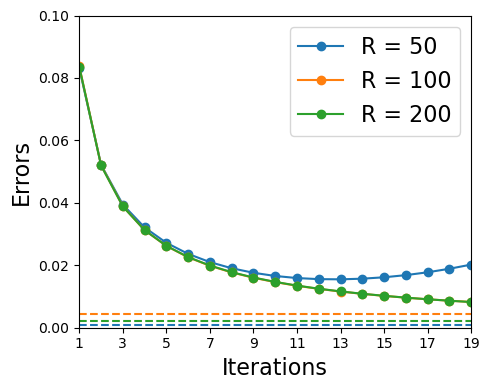

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for the three cases
case_files = [
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Curvature_R50_Iteration_1_20_new.npz",
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Curvature_R100_Iteration_1_20_new.npz",
    "/Users/lin/projects/VECTOR/examples/curvature_calculation/BL3D_Curvature_R200_Iteration_1_20_new.npz"
]

# Load data for each case
BL_errors_cases = []
for file in case_files:
    data = np.load(file)
    BL_errors_cases.append(data['BL_errors'])

loop_times = np.arange(1, len(BL_errors_cases[0]) + 1)

# Plot BL_errors for the three cases
plt.figure(figsize=(5, 4))
labels = ["R = 50", "R = 100", "R = 200"]
for i, BL_errors in enumerate(BL_errors_cases):
    plt.plot(loop_times, BL_errors, label=f"{labels[i]}", c=f"C{i}", marker='o')

# plot results from I-O method
I_O_method_results = [0.0008, 0.0044, 0.0021]

for i, I_O_method_result in enumerate(I_O_method_results):
    plt.plot(loop_times, [I_O_method_result] * len(loop_times), c=f"C{i}", linestyle='--')

plt.xlabel("Iterations",fontsize=16)
plt.ylabel("Errors",fontsize=16)
plt.xlim(1, 19)
plt.xticks(np.arange(1, 21, 2))
plt.ylim(0, 0.1)
plt.legend(fontsize=16)
# plt.grid(True)
plt.tight_layout()
plt.savefig("BL3D_Curvature_3Radius.png", dpi=300)

In [6]:
# IO method
GB_radius_list = [50, 100, 200]
for i in range(len(P0_sphere_list)):
    P0_step0 = P0_sphere_list[i]
    GB_radius = GB_radius_list[i]

    curvature_dict_IO_step0_sphere = post_processing.IO_curvature(P0_step0)

    print("Curvature matrix shape:", len(curvature_dict_IO_step0_sphere))
    print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
    for key, value in curvature_dict_IO_step0_sphere.items():
        if key == 2:
            print(f"GB id in step 0: {key}, Value: {value}")
    # analytical value
    analytical_curvature = 1 / GB_radius
    print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(curvature_dict_IO_step0_sphere[2][3],5)} error: {abs(analytical_curvature - curvature_dict_IO_step0_sphere[2][3])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 1
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [2.82240000e+04 2.70240000e+04 4.71600000e+04 1.99846861e-02]
Analytical curvature: 0.02, calculated curvature: 0.01998 error: 0.08%
Curvature matrix shape: 1
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [1.11552000e+05 1.09164000e+05 1.88382000e+05 9.95599799e-03]
Analytical curvature: 0.01, calculated curvature: 0.00996 error: 0.44%
Curvature matrix shape: 1
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [4.43748000e+05 4.38960000e+05 7.53654000e+05 4.98967219e-03]
Analytical curvature: 0.005, calculated curvature: 0.00499 error: 0.21%


NameError: name 'curvature_matrix_step0' is not defined

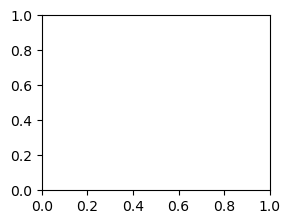

In [4]:
# Visualize mid-slices
plt.figure(figsize=(10, 5))

# curvatrue X-slice
plt.subplot(231)
plt.imshow(curvature_matrix_step0[nx//2, :, :], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(label='Grain ID')

# curvatrue Y-slice
plt.subplot(232)
plt.imshow(curvature_matrix_step0[:, ny//2, :], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(label='Grain ID')

# curvatrue Z-slice at cylinder half-height
plt.subplot(233)
plt.imshow(curvature_matrix_step0[:, :, start_z_step0 + cylinder_height_step0 + 5], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'Z-Slice at z={start_z_step0 + cylinder_height_step0 + 5}')
plt.colorbar(label='Grain ID')

# curvatrue X-slice
plt.subplot(234)
plt.imshow(curvature_matrix_step1[nx//2, :, :], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(label='Grain ID')

# curvatrue Y-slice
plt.subplot(235)
plt.imshow(curvature_matrix_step1[:, ny//2, :], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(label='Grain ID')

# curvatrue Z-slice at cylinder half-height
plt.subplot(236)
plt.imshow(curvature_matrix_step1[:, :, start_z_step1 + cylinder_height_step1 + 5], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'Z-Slice at z={start_z_step1 + cylinder_height_step1 + 5}')
plt.colorbar(label='Grain ID')

plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict
from scipy.spatial import cKDTree

TJ_distance_max = 5

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0_step0, -1, axis=0),
    np.roll(P0_step0, 1, axis=0),
    np.roll(P0_step0, -1, axis=1),
    np.roll(P0_step0, 1, axis=1),
    np.roll(P0_step0, -1, axis=2),
    np.roll(P0_step0, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0_step0[None,...]).any(axis=0)
boundary_coords = np.argwhere(boundary_mask)

# First pass: Build TJ_information_dict and organize TJ points by pair_id
TJ_infomation_dict = defaultdict(list)
TJ_trees = {}  # KD-trees for each pair_id's TJ points
neighbor_array = neighbors.reshape(6, -1).T

# Process boundary points for triple junctions
for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

    if len(unique_neighbors) > 1:  # Triple junction point
        for neighbor in unique_neighbors:
            pair_id = post_processing.get_line(central_site, neighbor)
            TJ_infomation_dict[pair_id].append([i,j,k])
print("Finish TJ information collection")
# Create KD-trees for each pair_id's TJ points
for pair_id, tj_points in TJ_infomation_dict.items():
    tj_points_array = np.array(tj_points)
    TJ_trees[pair_id] = cKDTree(tj_points_array)

# Second pass: Build GB_information_dict
GB_infomation_dict = {}

# Process boundary points for grain boundaries
# Group boundary points by pair_id for batch processing
gb_points_by_pair = defaultdict(list)
gb_central_sites = defaultdict(list)
gb_indices = defaultdict(list)

for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

    if len(unique_neighbors) == 1:  # Single boundary point
        neighbor = unique_neighbors[0]
        pair_id = post_processing.get_line(central_site, neighbor)
        pair_id_pair = sorted([central_site, neighbor])

        # First update or create GB area count
        if pair_id in GB_infomation_dict:
            GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
        else:
            GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
            GB_infomation_dict[pair_id] = GB_infomation

        # Collect points for batch processing
        gb_points_by_pair[pair_id].append([i,j,k])
        gb_central_sites[pair_id].append(central_site)
        gb_indices[pair_id].append([i,j,k])
print("Finish GB information collection")

# Process each pair_id's points in batch
for pair_id, points in gb_points_by_pair.items():
    points_array = np.array(points)
    central_sites = np.array(gb_central_sites[pair_id])
    indices = np.array(gb_indices[pair_id])

    # If there are TJ points for this pair_id, check distances
    if pair_id in TJ_trees:
        # Find distances to nearest TJ points for all GB points at once
        distances, _ = TJ_trees[pair_id].query(points_array)
        # Create mask for points far enough from TJ
        far_from_tj_mask = distances >= TJ_distance_max

        # Process only points far from TJ
        valid_points = points_array[far_from_tj_mask]
        valid_central_sites = central_sites[far_from_tj_mask]
        valid_indices = indices[far_from_tj_mask]

        # Update GB information for valid points
        n_valid = len(valid_points)
        if n_valid == 0: continue
        GB_infomation_dict[pair_id][0] += n_valid

        # Calculate curvature signs based on central_site matching pair_id_pair[0]
        curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)

        # Update position and curvature information
        pos_ave = np.sum(valid_indices, axis=0) / n_valid
        curv_ave = np.sum(curvature_signs * curvature_matrix_step0[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
        GB_infomation_dict[pair_id][1:4] += pos_ave
        GB_infomation_dict[pair_id][4] += curv_ave
print("Finsh GB information dictionary")

# Post-process GB information
GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

print(f"Current GBs len: {len(GB_infomation_dict)}")

GB_infomation_dict_step0 = GB_infomation_dict.copy()

Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6


In [ ]:
from collections import defaultdict
from scipy.spatial import cKDTree

TJ_distance_max = 5

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0_step1, -1, axis=0),
    np.roll(P0_step1, 1, axis=0),
    np.roll(P0_step1, -1, axis=1),
    np.roll(P0_step1, 1, axis=1),
    np.roll(P0_step1, -1, axis=2),
    np.roll(P0_step1, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0_step1[None,...]).any(axis=0)
boundary_coords = np.argwhere(boundary_mask)

# First pass: Build TJ_information_dict and organize TJ points by pair_id
TJ_infomation_dict = defaultdict(list)
TJ_trees = {}  # KD-trees for each pair_id's TJ points
neighbor_array = neighbors.reshape(6, -1).T

# Process boundary points for triple junctions
for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step1[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

    if len(unique_neighbors) > 1:  # Triple junction point
        for neighbor in unique_neighbors:
            pair_id = post_processing.get_line(central_site, neighbor)
            TJ_infomation_dict[pair_id].append([i,j,k])
print("Finish TJ information collection")
# Create KD-trees for each pair_id's TJ points
for pair_id, tj_points in TJ_infomation_dict.items():
    tj_points_array = np.array(tj_points)
    TJ_trees[pair_id] = cKDTree(tj_points_array)

# Second pass: Build GB_information_dict
GB_infomation_dict = {}

# Process boundary points for grain boundaries
# Group boundary points by pair_id for batch processing
gb_points_by_pair = defaultdict(list)
gb_central_sites = defaultdict(list)
gb_indices = defaultdict(list)

for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step1[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])

    if len(unique_neighbors) == 1:  # Single boundary point
        neighbor = unique_neighbors[0]
        pair_id = post_processing.get_line(central_site, neighbor)
        pair_id_pair = sorted([central_site, neighbor])

        # First update or create GB area count
        if pair_id in GB_infomation_dict:
            GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
        else:
            GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
            GB_infomation_dict[pair_id] = GB_infomation

        # Collect points for batch processing
        gb_points_by_pair[pair_id].append([i,j,k])
        gb_central_sites[pair_id].append(central_site)
        gb_indices[pair_id].append([i,j,k])
print("Finish GB information collection")

# Process each pair_id's points in batch
for pair_id, points in gb_points_by_pair.items():
    points_array = np.array(points)
    central_sites = np.array(gb_central_sites[pair_id])
    indices = np.array(gb_indices[pair_id])

    # If there are TJ points for this pair_id, check distances
    if pair_id in TJ_trees:
        # Find distances to nearest TJ points for all GB points at once
        distances, _ = TJ_trees[pair_id].query(points_array)
        # Create mask for points far enough from TJ
        far_from_tj_mask = distances >= TJ_distance_max

        # Process only points far from TJ
        valid_points = points_array[far_from_tj_mask]
        valid_central_sites = central_sites[far_from_tj_mask]
        valid_indices = indices[far_from_tj_mask]

        # Update GB information for valid points
        n_valid = len(valid_points)
        if n_valid == 0: continue
        GB_infomation_dict[pair_id][0] += n_valid

        # Calculate curvature signs based on central_site matching pair_id_pair[0]
        curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)

        # Update position and curvature information
        pos_ave = np.sum(valid_indices, axis=0) / n_valid
        curv_ave = np.sum(curvature_signs * curvature_matrix_step1[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
        GB_infomation_dict[pair_id][1:4] += pos_ave
        GB_infomation_dict[pair_id][4] += curv_ave
print("Finsh GB information dictionary")

# Post-process GB information
GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

print(f"Current GBs len: {len(GB_infomation_dict)}")

GB_infomation_dict_step1 = GB_infomation_dict.copy()

Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6


In [84]:
print("Curvature matrix shape:", len(GB_infomation_dict))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in GB_infomation_dict_step0.items():
    if key == 2:
        print(f"GB id in step 0: {key}, Value: {value}")
for key, value in GB_infomation_dict_step1.items():
    if key == 2:
        print(f"GB id in step 1: {key}, Value: {value}")
# analytical value
analytical_curvature = 1 / GB_radius
print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(GB_infomation_dict[2][4],5)} error: {abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 6
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [1.25700000e+04 1.00000000e+02 1.00000000e+02 1.28835243e+02
 5.18224827e-03 1.51300000e+04 1.00000000e+00 2.00000000e+00]
GB id in step 1: 2, Value: [1.25700000e+04 1.00000000e+02 1.00000000e+02 1.58835243e+02
 5.18224827e-03 1.51300000e+04 1.00000000e+00 2.00000000e+00]
Analytical curvature: 0.005, calculated curvature: 0.00518 error: 3.64%


# get velocity from VECTOR

In [ ]:

def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
    growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
    growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
    return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)

def compute_necessary_info_split(key,time_interval,
                            GB_infomation_dict_list_one_step_one_key,
                            npy_file_aniso_current,
                            npy_file_aniso_next):


    # Calculate dV and velocity
    dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
    velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
    # keep curvature
    current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]

    result = {
        "key": key,
        "velocity": velocity,
        "dV_direction1": dV_direction1,
        "dV_direction2": dV_direction2,
        "current_curvature_value": current_curvature_value,
        "is_anti_curvature": current_curvature_value * velocity < -1e-4 # not large difference, no GB in [-1e-4,0]
    }

    return result

time_interval = 1
result = compute_necessary_info_split(key,time_interval,GB_infomation_dict[2],P0_step0,P0_step1)

print("Velocity:", result["velocity"])
print("dV_direction1:", result["dV_direction1"])
print("dV_direction2:", result["dV_direction2"])
print("Current curvature value:", result["current_curvature_value"])
print("Is anti-curvature:", result["is_anti_curvature"])


Velocity: -31.110376734963648
dV_direction1: 0
dV_direction2: 235350
Current curvature value: 0.005182248269570522
Is anti-curvature: True
